In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install gym_cartpole_swingup

     |████████████████████████████████| 1.6MB 6.0MB/s 
  Created wheel for gym: filename=gym-0.18.0-cp37-none-any.whl size=1656450 sha256=0d1464125ae22905fe008a6f4a1426d37d27ce453191da51c2e479f14b79932c
  Stored in directory: /root/.cache/pip/wheels/be/85/3b/480b828a4a697b37392740a040b8989f729d952b4e441a1877
Successfully built gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [ ]:
pip install stable_baselines3

     |████████████████████████████████| 153kB 5.7MB/s 


In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import gym
import gym_cartpole_swingup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import seaborn as sb
import math
from IPython.display import clear_output
import time

In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import IsolationForest
from pyvirtualdisplay import Display

In [ ]:
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common import results_plotter

In [ ]:
lbr = "\n"

Helper Functions

In [220]:
pathprefix = "/content/"
googledrive_dir = "/content/drive/MyDrive/ARL/"
os.makedirs(googledrive_dir, exist_ok=True)
log_dir1 = googledrive_dir + "logs1"
log_dir2 = googledrive_dir + "logs2"
log_dir = googledrive_dir + "logs"
os.makedirs(log_dir1, exist_ok=True)
os.makedirs(log_dir2, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

sample_dir = googledrive_dir + "samples" 
os.makedirs(sample_dir, exist_ok=True)

model_dir = googledrive_dir + "models"
os.makedirs(model_dir, exist_ok=True)

fig_dir = googledrive_dir + "figures"
os.makedirs(fig_dir, exist_ok=True)

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

ObservationWrapper

In [ ]:
class NoisedObservationWrapper(gym.Wrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))

    def __init__(self, env, std_dev=0.3, mean=0, angle_min=10, angle_max=20, local_path="false"):
        super().__init__(env)
        self.env = env
        self.std_dev = std_dev
        self.mean = mean
        self.angle_min = np.radians(angle_min)
        self.angle_max = np.radians(angle_max)
        self.local_path = local_path
        
        if(self.local_path != "false"):
            log_file = open(self.local_path, "w")
            log_file.close()

    def step(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info
    
    def step_examine(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        uncertainty = 0
        old_reward = reward

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info, noisy, uncertainty, old_reward

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [ ]:
def wrap_env(env):
  env = Monitor(env, './video')
  return env

Sampling Environment

In [ ]:
CART_POS="cartPos"
CART_VEL="cartVel"
PEND_POS="pendPos"
PEND_POS_SIN="pendPosSin"
PEND_POS_COS="pendPosCos"
PEND_VEL="pendVel"
EPISODE="episode"
STEP="step"
ACTION="action"

d = {
        CART_POS:[], CART_VEL:[], 
        PEND_POS:[], PEND_VEL:[],
        EPISODE:[], STEP:[], ACTION:[]
    }

In [ ]:
# Setup Environment

goal_steps = 500
score_requirement =  100
initial_games = 10000
sample_episodes = 100
sample_max_length = 500
LR = 1e-3
env = wrap_env(NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0")))
env.reset()
env.np_random.seed(0)

In [ ]:
def sample_data():

    ### CREATE EMPTY Pandas dataset
    df = pd.DataFrame(data=d)

    ### SAMPLE DATA
    for episode in range (sample_episodes):
        obs = env.reset()
        step =0
        done = False
        
        while step < sample_max_length and not done:
            step += 1
            action = env.action_space.sample()
            action = action[0] # convert to float
            df = df.append ({CART_POS:obs[0], CART_VEL:obs[1], 
                            PEND_POS:obs[2], PEND_VEL:obs[3],
                            EPISODE:episode, STEP:step, ACTION:action}, ignore_index=True)
            
            obs, reward, done, _ = env.step(action)
        clear_output(wait=True)
        print("Sample Episode: " + str(episode+1))
    return df

In [ ]:
df = sample_data()

Sample Episode: 100


In [ ]:
sample_file = sample_dir + "/" + "sample200.csv"

In [ ]:
df.to_csv(path_or_buf=sample_file, index=False)

In [ ]:
samples = pd.read_csv(sample_file, engine='python', index_col=None)

Sample Examination

In [ ]:
samples.head()

,cartPos,cartVel,pendPos,pendVel,episode,step,action
0,0.047105,-0.065778,-0.996934,-0.078249,0.0,1.0,0.317565
1,0.046447,-0.010467,-0.996855,-0.079243,0.0,2.0,-0.300028
2,0.046343,-0.053637,-0.996901,-0.078671,0.0,3.0,-0.957797
3,0.045806,-0.201628,-0.996876,-0.078978,0.0,4.0,-0.868926
4,0.043790,-0.335168,-0.996569,-0.082769,0.0,5.0,-0.869852


In [ ]:
plot = samples.plot(subplots=True, figsize=(20,20), grid=True)
fig = plot[0].get_figure()
fig.savefig(fig_dir + "/sampleplot.png")

In [ ]:
row_max_steps = samples.loc[samples['step'].idxmax()]
print (row_max_steps)

In [ ]:
samplesEval = samples[samples.episode==row_max_steps.episode]
samplesEval.describe()

Dataset

In [ ]:
markov_head = 4

In [ ]:
sample_length = len(samples.index)
print((samples[sample_length-1:sample_length]).to_numpy()[0][4])

199.0


In [ ]:
store = []

dataset = pd.DataFrame()

i = 0

print("Episode: " + str(0))

while (i < sample_length ) :

  new_data = (samples[i:i+1]).to_numpy()[0]

  pendPos = new_data[2]
  pendPosSin = math.sin(pendPos)
  pendPosCos = math.cos(pendPos)

  new_data[2] = pendPosSin
  new_data = np.insert(new_data, 3, pendPosCos)

  store.append(new_data)

  #print(new_data)

  if(len(store) == markov_head + 1):
    if store[0][5] == store[markov_head][5]:
        j = 0
        data = {}
        for j in range(markov_head+1):
          data[CART_POS + str(j+1)] = store[j][0]
          data[CART_VEL + str(j+1)] = store[j][1]
          data[PEND_POS_SIN + str(j+1)] = store[j][2]
          data[PEND_POS_COS + str(j+1)] = store[j][3]
          data[PEND_VEL + str(j+1)] = store[j][4]
          data[ACTION + str(j+1)] = store[j][7]

        #print(data)
        dataset = dataset.append (data, ignore_index=True)
        store.pop(0)
    else:
      clear_output(wait=True)
      print("Episode: " + str(store[markov_head][5]))
      store = [new_data]
  i += 1

print(dataset)

Episode: 1999.0
         action1   action2   action3  ...  pendVel3  pendVel4  pendVel5
0      -0.322456 -0.938358 -0.901102  ... -0.315415 -0.318757 -0.324048
1      -0.938358 -0.901102  0.358997  ... -0.318757 -0.324048 -0.327000
2      -0.901102  0.358997  0.533705  ... -0.324048 -0.327000 -0.327028
3       0.358997  0.533705  0.047232  ... -0.327000 -0.327028 -0.325766
4       0.533705  0.047232 -0.722394  ... -0.327028 -0.325766 -0.325798
...          ...       ...       ...  ...       ...       ...       ...
844651 -0.638094  0.918343  0.549583  ... -0.605822 -0.611436 -0.614326
844652  0.918343  0.549583  0.181291  ... -0.611436 -0.614326 -0.615274
844653  0.549583  0.181291  0.975912  ... -0.614326 -0.615274 -0.612673
844654  0.181291  0.975912 -0.862666  ... -0.615274 -0.612673 -0.610247
844655  0.975912 -0.862666  0.801695  ... -0.612673 -0.610247 -0.604592

[844656 rows x 30 columns]


In [ ]:
processed_sample_file = sample_dir + "/" + "processed_sample_200.csv"

In [ ]:
dataset.to_csv(path_or_buf=processed_sample_file, index=False)

In [ ]:
dataset = pd.read_csv(processed_sample_file, engine='python', index_col=None)

In [ ]:
print(dataset)

        action1   action2   action3  ...  pendVel3  pendVel4  pendVel5
0      0.317565 -0.300028 -0.957797  ... -0.078671 -0.078978 -0.082769
1     -0.300028 -0.957797 -0.868926  ... -0.078978 -0.082769 -0.089680
2     -0.957797 -0.868926 -0.869852  ... -0.082769 -0.089680 -0.099686
3     -0.868926 -0.869852 -0.065332  ... -0.089680 -0.099686 -0.109566
4     -0.869852 -0.065332 -0.387545  ... -0.099686 -0.109566 -0.120548
...         ...       ...       ...  ...       ...       ...       ...
81043 -0.477167  0.557596  0.010023  ...  0.625119  0.606252  0.585305
81044  0.557596  0.010023 -0.409669  ...  0.606252  0.585305  0.561299
81045  0.010023 -0.409669  0.149883  ...  0.585305  0.561299  0.535339
81046 -0.409669  0.149883  0.090151  ...  0.561299  0.535339  0.507253
81047  0.149883  0.090151  0.213874  ...  0.535339  0.507253  0.477329

[81048 rows x 30 columns]


Uncertainty Modeling

In [ ]:
inputs = []

j = 0
data = {}
for j in range(markov_head):
  inputs.append(CART_POS + str(j+1))
  inputs.append(CART_VEL + str(j+1))
  inputs.append(PEND_POS_SIN + str(j+1))
  inputs.append(PEND_POS_COS + str(j+1))
  inputs.append(PEND_VEL + str(j+1))
  inputs.append(ACTION + str(j+1))

outputs = [CART_POS + str(markov_head+1), CART_VEL + str(markov_head+1), PEND_POS_SIN + str(markov_head+1), PEND_POS_COS + str(markov_head+1), PEND_VEL + str(markov_head+1)]

print(inputs)
print(len(inputs))
print(outputs)
print(len(outputs))

['cartPos1', 'cartVel1', 'pendPosSin1', 'pendPosCos1', 'pendVel1', 'action1', 'cartPos2', 'cartVel2', 'pendPosSin2', 'pendPosCos2', 'pendVel2', 'action2', 'cartPos3', 'cartVel3', 'pendPosSin3', 'pendPosCos3', 'pendVel3', 'action3', 'cartPos4', 'cartVel4', 'pendPosSin4', 'pendPosCos4', 'pendVel4', 'action4']
24
['cartPos5', 'cartVel5', 'pendPosSin5', 'pendPosCos5', 'pendVel5']
5


In [ ]:
input_data = dataset[inputs].values
output_data = dataset[outputs].values

BNN (based on https://towardsdatascience.com/bayesian-neural-networks-with-tensorflow-probability-fbce27d6ef6 and https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html)

In [ ]:
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [ ]:
bnn_epochs = 100
bnn_train_ratio = 0.3
bnn_samples = dataset.shape[0]
bnn_batches = 10
bnn_batch_size = np.floor(bnn_samples/bnn_batches)
bnn_buffer_size = bnn_samples

bnn_test_samples = 500
bnn_iterations = 20

In [ ]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)

Based on https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression

In [ ]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tfk.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [ ]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tfk.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

Aleatoric Uncertainty

In [ ]:
def al_model(size):
  return tfk.Sequential([
  tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
  tfk.layers.Dense(size, activation="relu", name="dense_1"),
  tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
  len(outputs)), activation=None, name="distribution_weights"),
  tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/bnn_batches), name="output")
  ], name="model")

In [ ]:
almodelpath = model_dir + "/" + "almodel.ckpt"
almodel = al_model(24)

# Compile model.
almodel.compile(optimizer="adam", loss=neg_log_likelihood)

almodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
distribution_weights (Dense) (None, 20)                500       
_________________________________________________________________
output (MultivariateNormalTr multiple                  0         
Total params: 1,100
Trainable params: 1,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
almodel.fit(x=input_data, y=output_data, validation_split= bnn_train_ratio, epochs=bnn_epochs,  verbose=True)
end = time.time()

print(end-start)

Epoch 1/100
1773/1773 [==============================] - 7s 3ms/step - loss: 5.1941 - val_loss: -3.1271
Epoch 2/100
1773/1773 [==============================] - 4s 2ms/step - loss: -4.7486 - val_loss: -8.2339
Epoch 3/100
1773/1773 [==============================] - 4s 2ms/step - loss: -4.1065 - val_loss: -7.9758
Epoch 4/100
1773/1773 [==============================] - 4s 2ms/step - loss: -2.8327 - val_loss: -4.4231
Epoch 5/100
1773/1773 [==============================] - 4s 2ms/step - loss: -4.9600 - val_loss: -6.9846
Epoch 6/100
1773/1773 [==============================] - 4s 2ms/step - loss: -6.8603 - val_loss: -7.0545
Epoch 7/100
1773/1773 [==============================] - 4s 2ms/step - loss: -4.3891 - val_loss: -2.2018
Epoch 8/100
1773/1773 [==============================] - 4s 2ms/step - loss: -2.7708 - val_loss: -4.3886
Epoch 9/100
1773/1773 [==============================] - 4s 2ms/step - loss: -4.7833 - val_loss: -6.9508
Epoch 10/100
1773/1773 [==============================] 

In [ ]:
almodel.save_weights(almodelpath.format(epoch=0))

In [ ]:
almodel = al_model(24)
almodel.compile(optimizer="adam", loss=neg_log_likelihood)
almodel.load_weights(almodelpath)

In [ ]:
X_true, Y_true, Y_pred = np.empty(shape=(bnn_test_samples, len(inputs))), np.empty(shape=(bnn_test_samples, len(outputs))), np.empty(shape=(bnn_test_samples, len(outputs), bnn_iterations))
for i in range(bnn_test_samples):
    clear_output(wait=True)
    print("Sample: " + str(i+1))

    eval_sample = dataset.sample()

    X_true[i,:] = eval_sample[inputs].values
    Y_true[i,:] = eval_sample[outputs].values
    #print("true")
    #print(Y_true[i,:])
    #print("prediction")
    for k in range(bnn_iterations):
        Y_pred[i,:,k] = almodel.predict(eval_sample[inputs].values)
        #print(Y_pred[i,:,k])


# Calculate mean and standard deviation.
#print("mean")
Y_pred_m = np.mean(Y_pred, axis=-1)
#print(Y_pred_m)
Y_pred_s = np.std(Y_pred, axis=-1)

Sample: 500


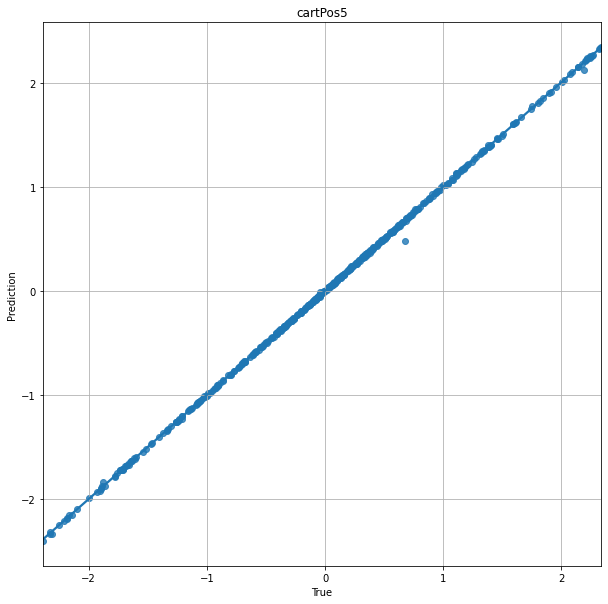

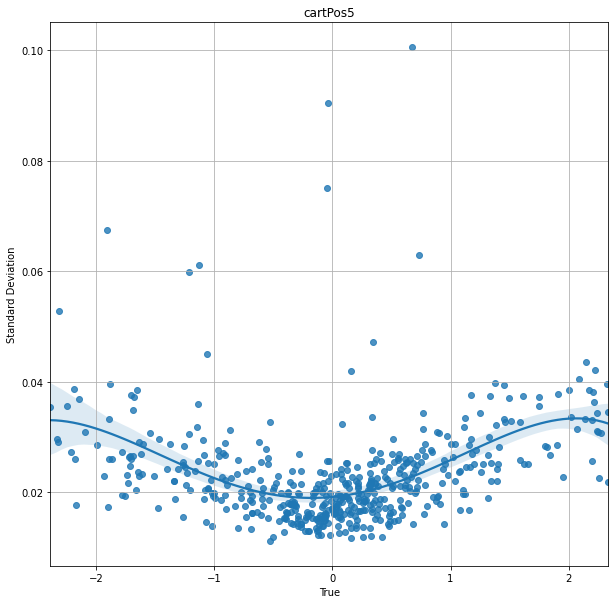

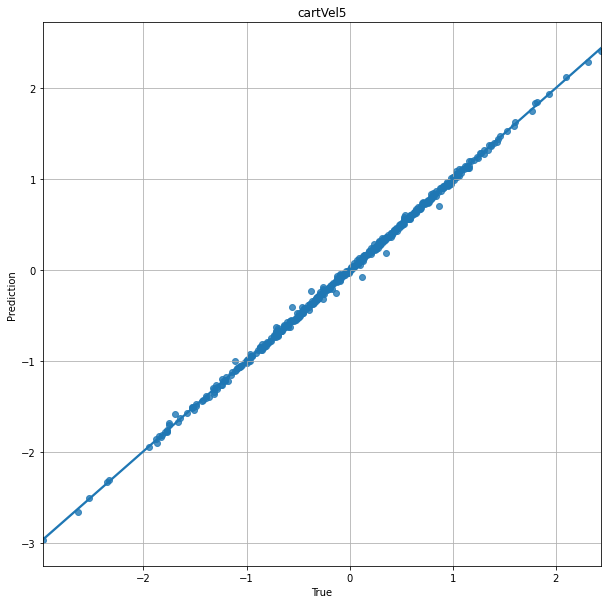

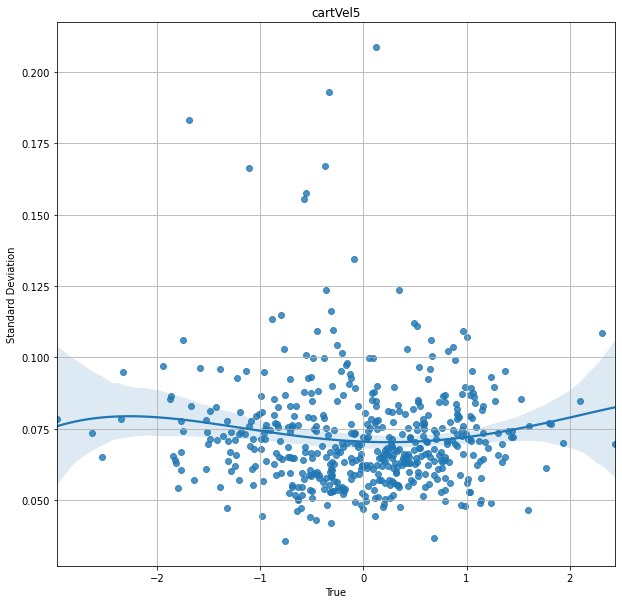

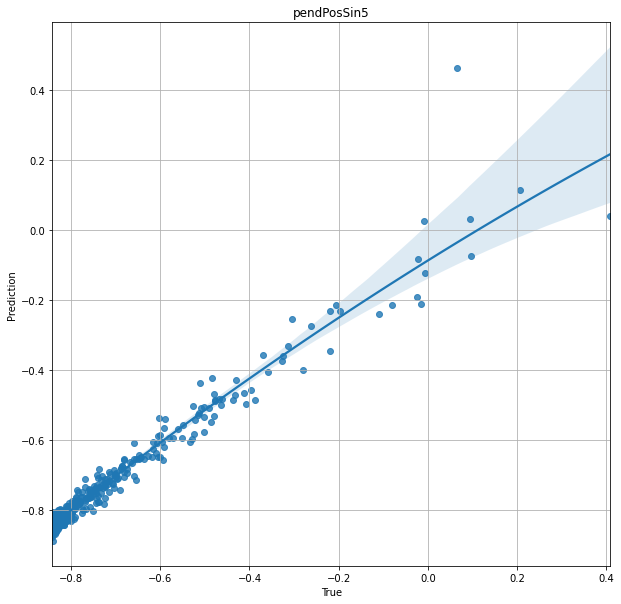

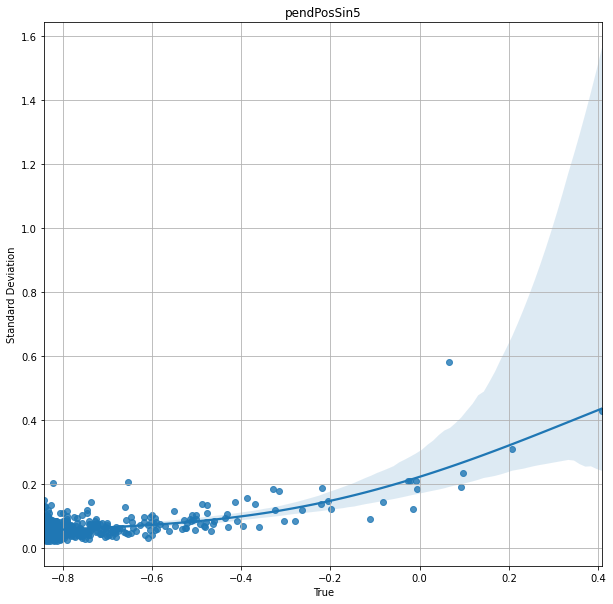

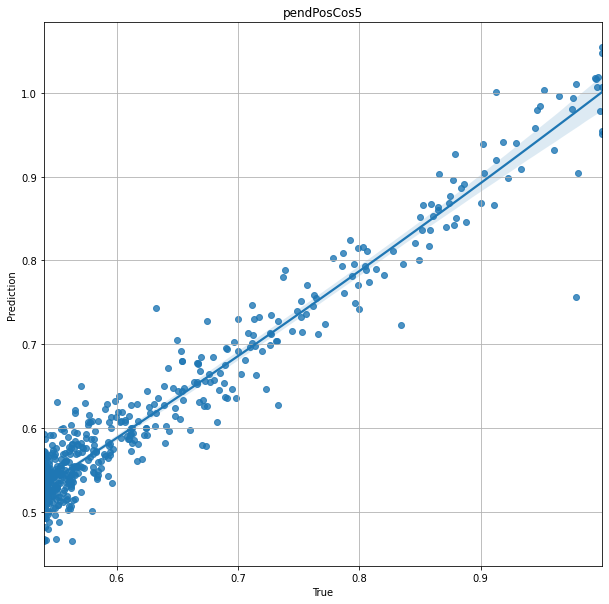

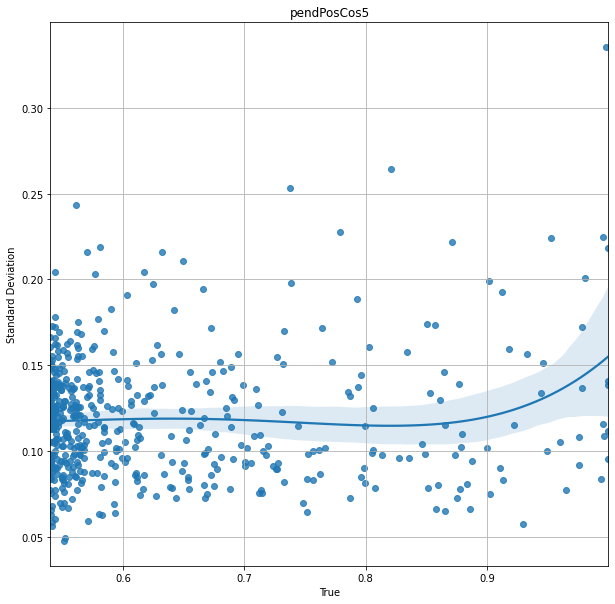

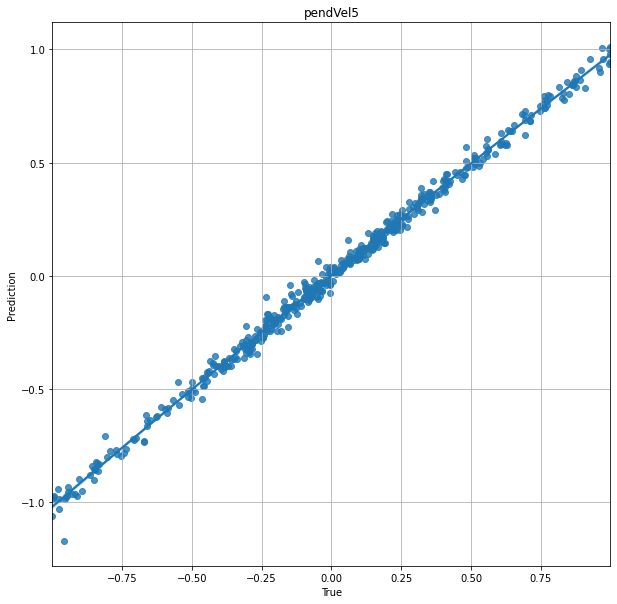

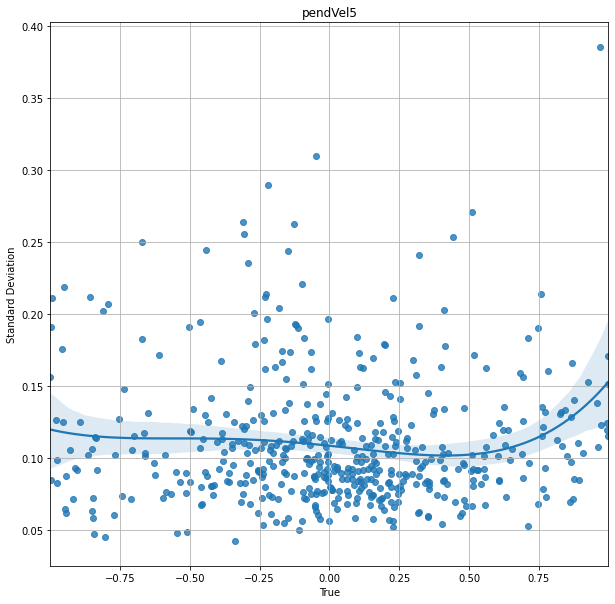

In [ ]:
Y_trueT = Y_true.transpose()
X_trueT = X_true.transpose()
Y_pred_sT = Y_pred_s.transpose()
Y_pred_mT = Y_pred_m.transpose()

for i in range(len(outputs)):
  fig, regplot = plt.subplots(figsize = (10,10))


  sb.regplot(x=Y_trueT[i], y=Y_pred_mT[i], fit_reg=True, scatter=True, order=2,truncate= True)

  regplot.set_xlabel("True")
  regplot.set_ylabel("Prediction")
  regplot.grid()

  plt.title(label=outputs[i])

  plt.savefig(fig_dir + "/almodel_predictions_" + outputs[i] + ".png")

  fig, regplot = plt.subplots(figsize = (10,10))

  sb.regplot(x=Y_trueT[i], y=Y_pred_sT[i], fit_reg=True, scatter=True, order=4,truncate= True)

  regplot.set_xlabel("True")
  regplot.set_ylabel("Standard Deviation")
  regplot.grid()

  plt.title(label=outputs[i])

  plt.savefig(fig_dir + "/almodel_sd_prediction_" + outputs[i] + ".png")

Epistemic Uncertainty using Dense Flipout Layer

In [ ]:
def ep_model(size):
  return tfk.Sequential([
  tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
  tfp.layers.DenseFlipout(size, activation="relu", name="dense_1"),
  tfp.layers.DenseFlipout(tfp.layers.MultivariateNormalTriL.params_size(
  len(outputs)), activation=None, name="distribution_weights"),
  tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/bnn_batches), name="output")
  ], name="model")

In [ ]:
epmodelpath = model_dir + "/" + "epmodel.ckpt"
epmodel = ep_model(24)

# Compile model.
epmodel.compile(optimizer="adam", loss=neg_log_likelihood)

epmodel.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (DenseFlipout)       (None, 24)                1176      
_________________________________________________________________
distribution_weights (DenseF (None, 20)                980       
_________________________________________________________________
output (MultivariateNormalTr multiple                  0         
Total params: 2,156
Trainable params: 2,156
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
epmodel.fit(x=input_data, y=output_data, validation_split= bnn_train_ratio, epochs=bnn_epochs,  verbose=True)
end = time.time()

print(end-start)

Epoch 1/100
1773/1773 [==============================] - 10s 4ms/step - loss: 2231.8226 - val_loss: 1016.2973
Epoch 2/100
1773/1773 [==============================] - 5s 3ms/step - loss: 873.6419 - val_loss: 639.0402
Epoch 3/100
1773/1773 [==============================] - 6s 3ms/step - loss: 627.5223 - val_loss: 1519.3921
Epoch 4/100
1773/1773 [==============================] - 5s 3ms/step - loss: 581.9359 - val_loss: 549.3179
Epoch 5/100
1773/1773 [==============================] - 5s 3ms/step - loss: 516.9923 - val_loss: 473.7803
Epoch 6/100
1773/1773 [==============================] - 6s 3ms/step - loss: 466.5327 - val_loss: 38061.3383
Epoch 7/100
1773/1773 [==============================] - 6s 3ms/step - loss: 439.7991 - val_loss: 517.5952
Epoch 8/100
1773/1773 [==============================] - 5s 3ms/step - loss: 391.8086 - val_loss: 391.1979
Epoch 9/100
1773/1773 [==============================] - 6s 3ms/step - loss: 370.6332 - val_loss: 8948.6118
Epoch 10/100
1773/1773 [======

In [ ]:
epmodel.save_weights(epmodelpath.format(epoch=0))

In [ ]:
epmodel = ep_model(24)
epmodel.compile(optimizer="adam", loss=neg_log_likelihood)
epmodel.load_weights(epmodelpath)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [ ]:
X_true, Y_true, Y_pred = np.empty(shape=(bnn_test_samples, len(inputs))), np.empty(shape=(bnn_test_samples, len(outputs))), np.empty(shape=(bnn_test_samples, len(outputs), bnn_iterations))
for i in range(bnn_test_samples):
    clear_output(wait=True)
    print("Sample: " + str(i+1))

    eval_sample = dataset.sample()

    X_true[i,:] = eval_sample[inputs].values
    Y_true[i,:] = eval_sample[outputs].values
    #print("true")
    #print(Y_true[i,:])
    #print("prediction")
    for k in range(bnn_iterations):
        Y_pred[i,:,k] = epmodel.predict(eval_sample[inputs].values)
        #print(Y_pred[i,:,k])


# Calculate mean and standard deviation.
#print("mean")
Y_pred_m = np.mean(Y_pred, axis=-1)
#print(Y_pred_m)
Y_pred_s = np.std(Y_pred, axis=-1)

Sample: 500


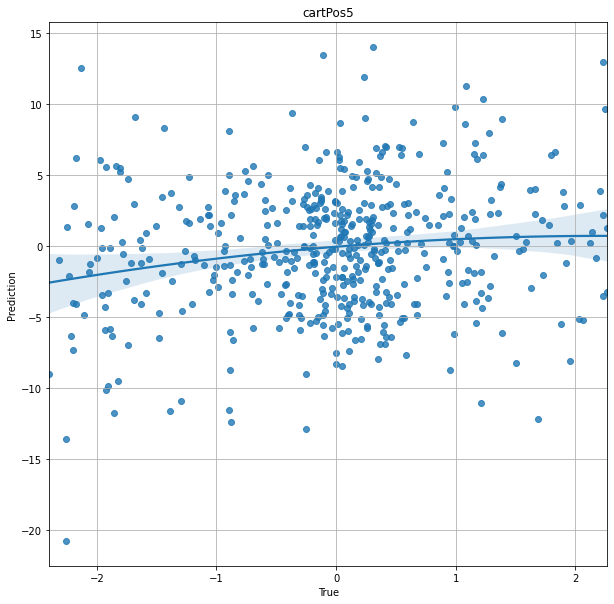

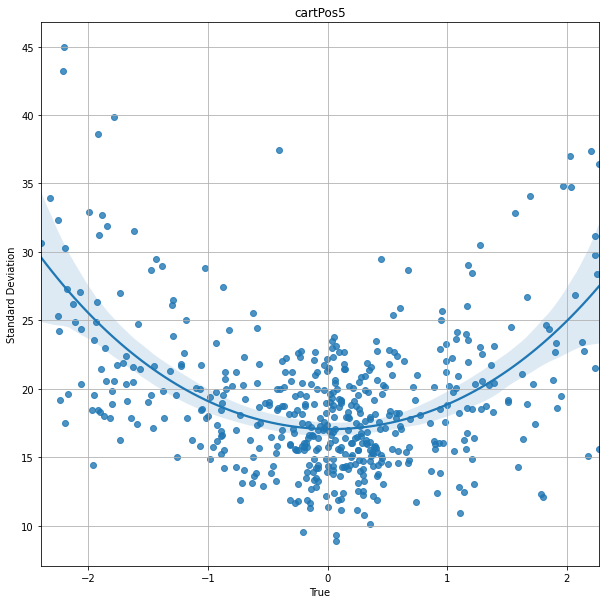

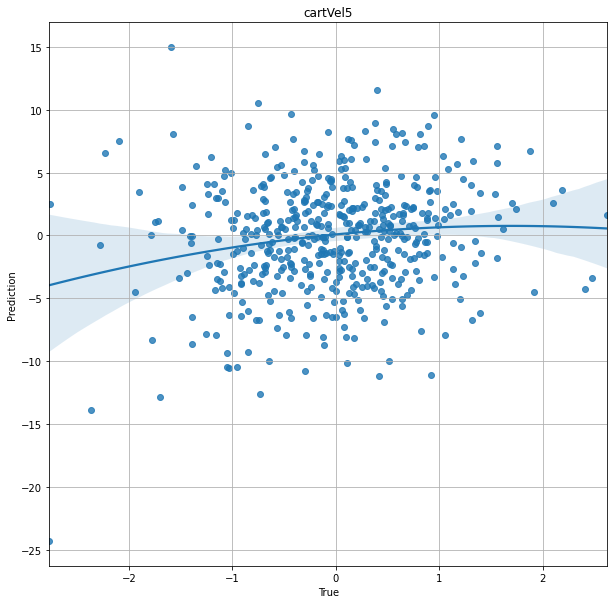

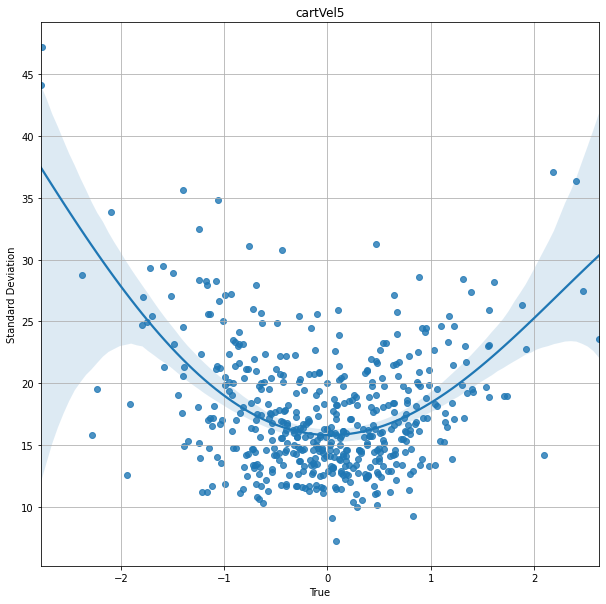

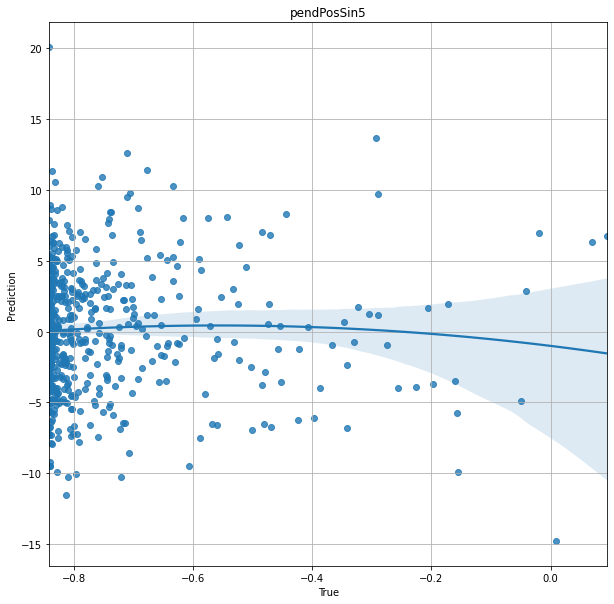

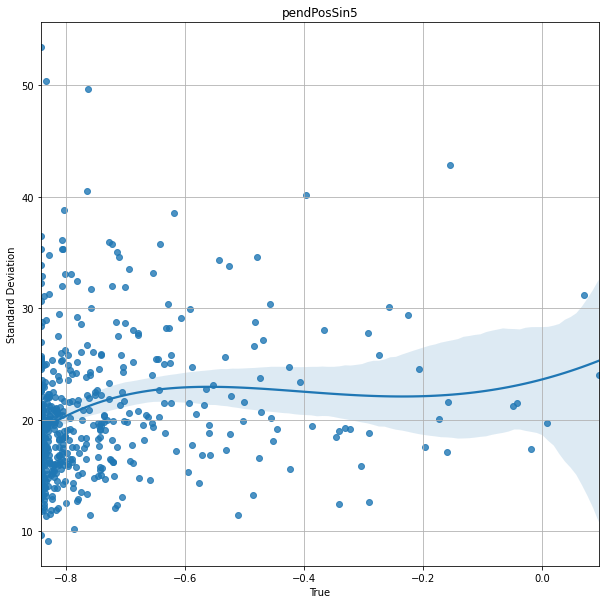

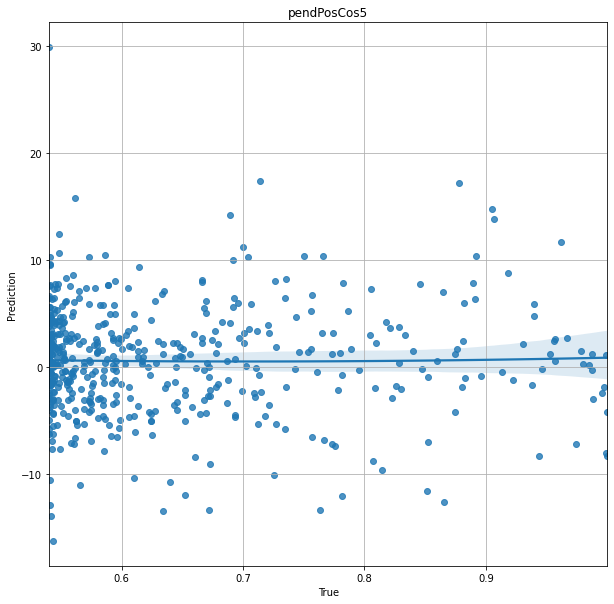

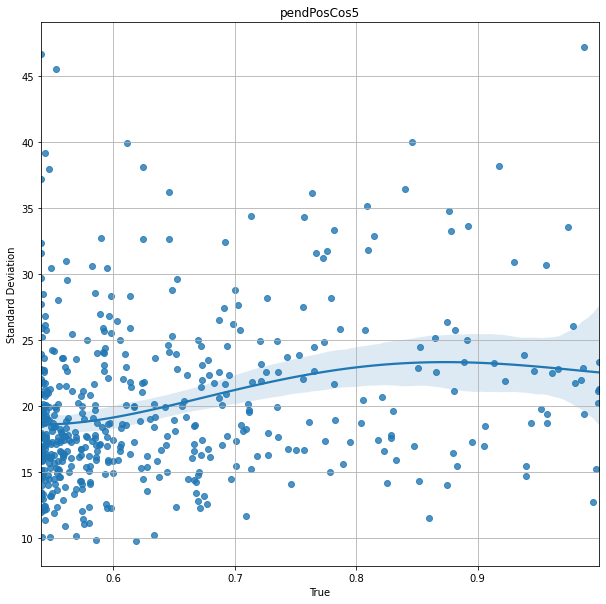

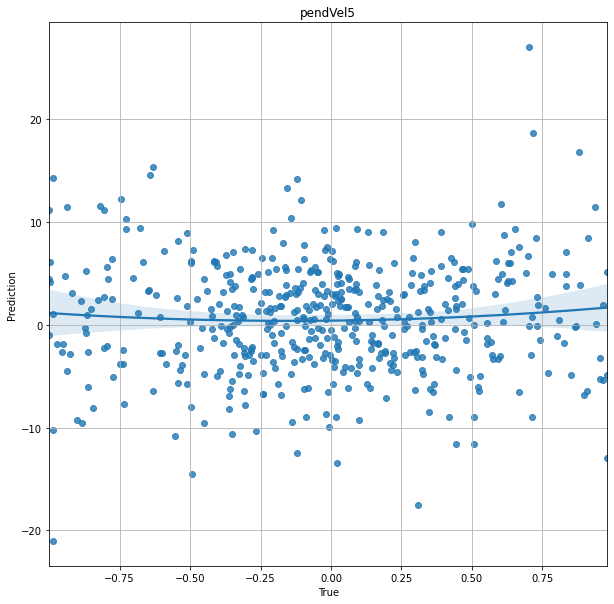

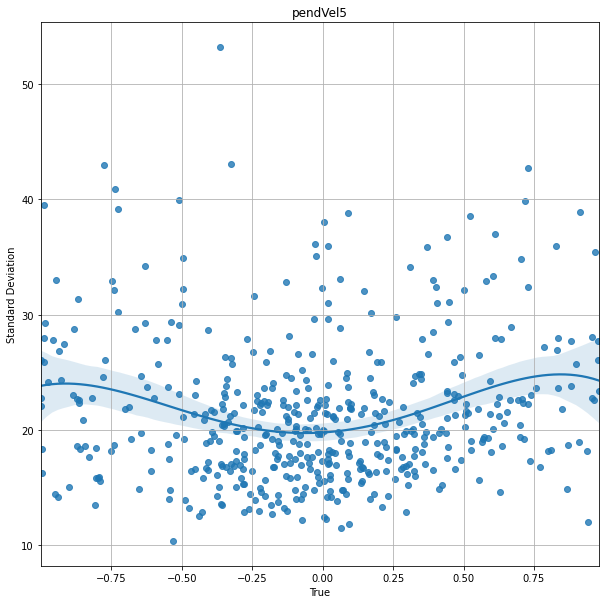

In [ ]:
Y_trueT = Y_true.transpose()
X_trueT = X_true.transpose()
Y_pred_sT = Y_pred_s.transpose()
Y_pred_mT = Y_pred_m.transpose()

for i in range(len(outputs)):
  fig, regplot = plt.subplots(figsize = (10,10))


  sb.regplot(x=Y_trueT[i], y=Y_pred_mT[i], fit_reg=True, scatter=True, order=2,truncate= True)

  regplot.set_xlabel("True")
  regplot.set_ylabel("Prediction")
  regplot.grid()

  plt.title(label=outputs[i])

  plt.savefig(fig_dir + "/epmodel_predictions_" + outputs[i] + ".png")

  fig, regplot = plt.subplots(figsize = (10,10))

  sb.regplot(x=Y_trueT[i], y=Y_pred_sT[i], fit_reg=True, scatter=True, order=4,truncate= True)

  regplot.set_xlabel("True")
  regplot.set_ylabel("Standard Deviation")
  regplot.grid()

  plt.title(label=outputs[i])

  plt.savefig(fig_dir + "/epmodel_sd_prediction_" + outputs[i] + ".png")

Epistemic Uncertainty using Dense Variational Layer

In [ ]:
def ep2_model(size):
  return tfk.Sequential([
  tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
  tfp.layers.DenseVariational(size, posterior_mean_field, prior_trainable, kl_weight=1/(len(inputs))),
  tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
  len(outputs)), activation=None, name="distribution_weights"),
  tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/bnn_batches), name="output")
  ], name="model")

In [ ]:
ep2modelpath = model_dir + "/" + "ep2model.ckpt"
ep2model = ep2_model(24)

# Compile model.
ep2model.compile(optimizer="adam", loss=neg_log_likelihood)

ep2model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 24)                1800      
_________________________________________________________________
distribution_weights (Dense) (None, 20)                500       
_________________________________________________________________
output (MultivariateNormalTr multiple                  0         
Total params: 2,300
Trainable params: 2,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
ep2model.fit(x=input_data, y=output_data, validation_split= bnn_train_ratio, epochs=bnn_epochs,  verbose=True)
end = time.time()

print(end-start)

Epoch 1/100
1773/1773 [==============================] - 9s 3ms/step - loss: inf - val_loss: inf
Epoch 2/100
1773/1773 [==============================] - 5s 3ms/step - loss: inf - val_loss: 522967554997437679300007503593472.0000
Epoch 3/100
1773/1773 [==============================] - 5s 3ms/step - loss: inf - val_loss: inf
Epoch 4/100
1773/1773 [==============================] - 5s 3ms/step - loss: inf - val_loss: 159905975419050013877176094425088.0000
Epoch 5/100
1773/1773 [==============================] - 5s 3ms/step - loss: inf - val_loss: inf
Epoch 6/100
1773/1773 [==============================] - 5s 3ms/step - loss: inf - val_loss: inf
Epoch 7/100
1773/1773 [==============================] - 5s 3ms/step - loss: inf - val_loss: inf
Epoch 8/100
1773/1773 [==============================] - 5s 3ms/step - loss: inf - val_loss: 31050144201576281011523757801472.0000
Epoch 9/100
1773/1773 [==============================] - 5s 3ms/step - loss: inf - val_loss: 304157304165667492032855785

In [ ]:
ep2model.save_weights(ep2modelpath.format(epoch=0))

In [ ]:
ep2model = ep2_model(24)
ep2model.compile(optimizer="adam", loss=neg_log_likelihood)
ep2model.load_weights(epmodelpath)

In [ ]:
X_true, Y_true, Y_pred = np.empty(shape=(bnn_test_samples, len(inputs))), np.empty(shape=(bnn_test_samples, len(outputs))), np.empty(shape=(bnn_test_samples, len(outputs), bnn_iterations))
for i in range(bnn_test_samples):
    clear_output(wait=True)
    print("Sample: " + str(i+1))

    eval_sample = dataset.sample()

    X_true[i,:] = eval_sample[inputs].values
    Y_true[i,:] = eval_sample[outputs].values
    #print("true")
    #print(Y_true[i,:])
    #print("prediction")
    for k in range(bnn_iterations):
        Y_pred[i,:,k] = ep2model.predict(eval_sample[inputs].values)
        #print(Y_pred[i,:,k])


# Calculate mean and standard deviation.
#print("mean")
Y_pred_m = np.mean(Y_pred, axis=-1)
#print(Y_pred_m)
Y_pred_s = np.std(Y_pred, axis=-1)

Sample: 500


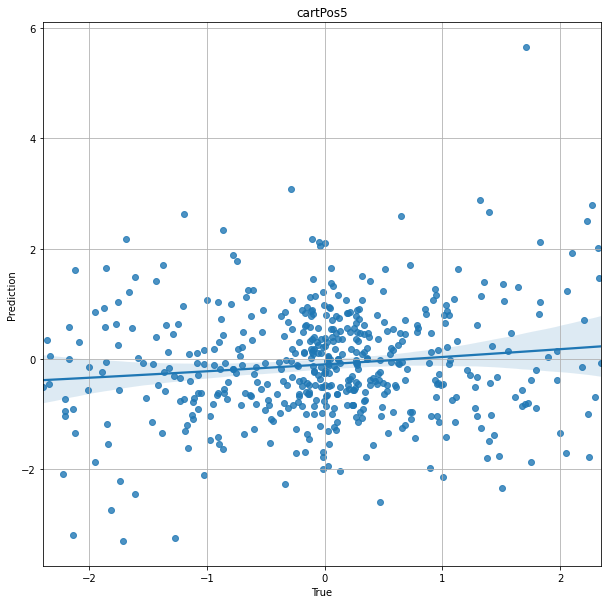

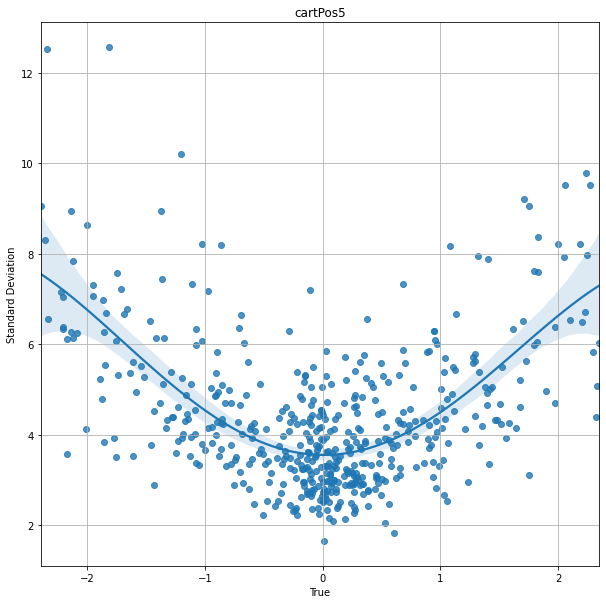

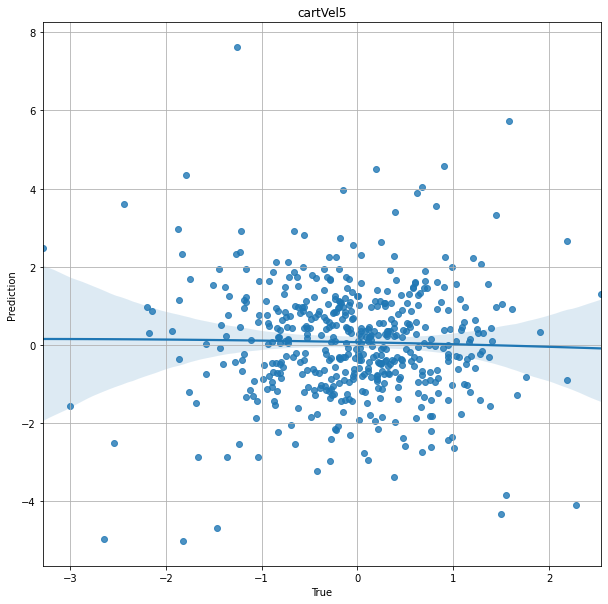

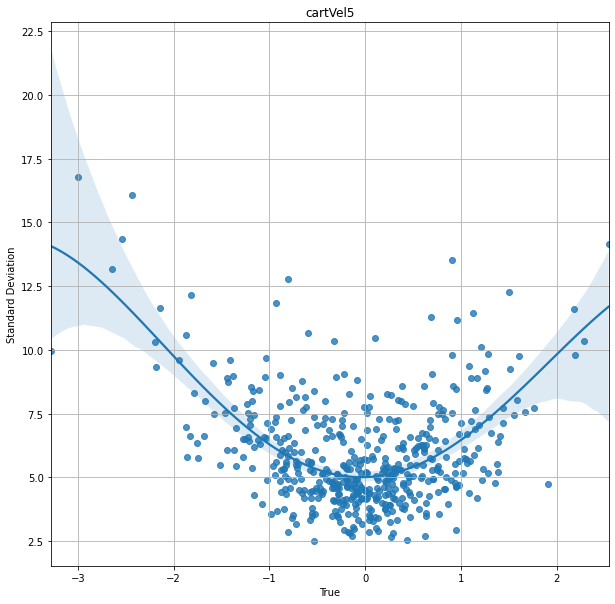

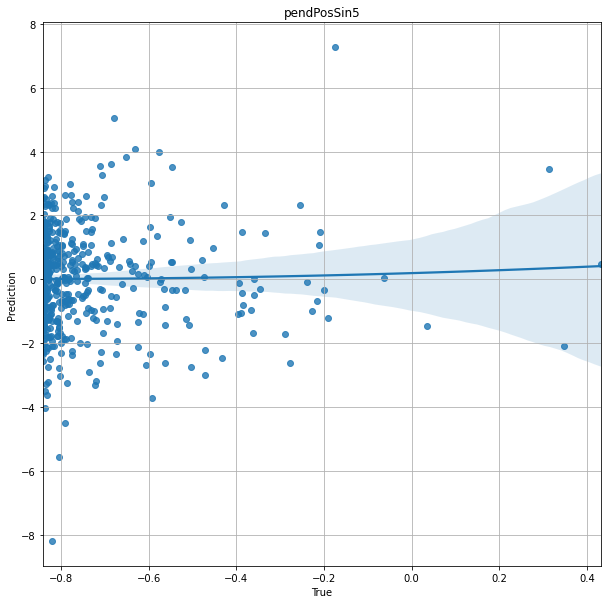

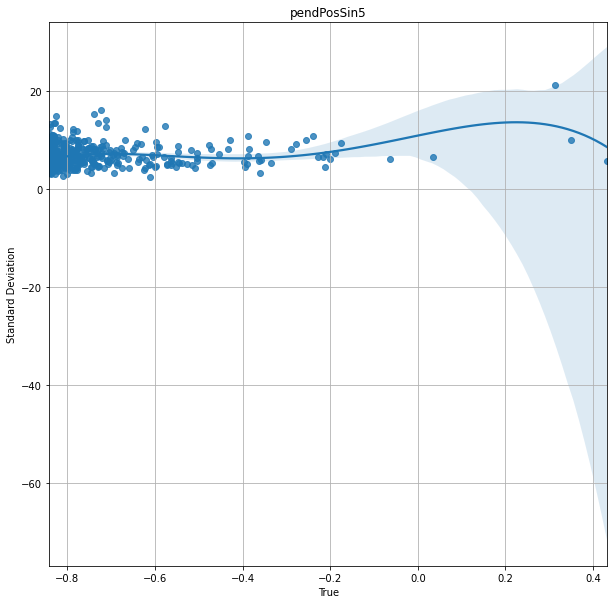

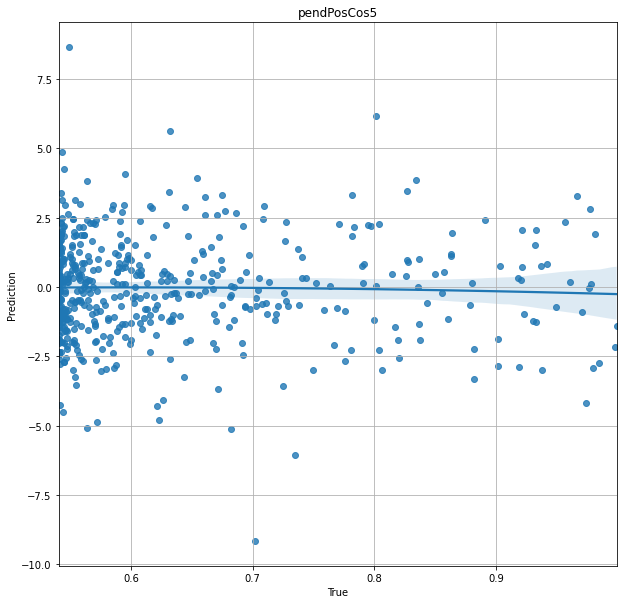

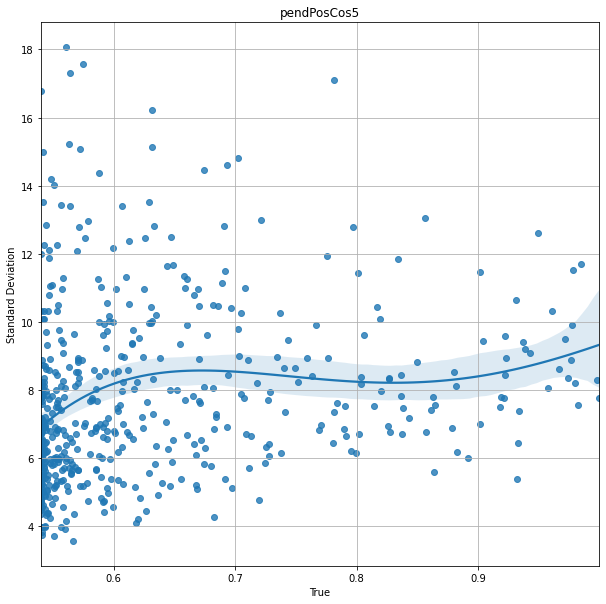

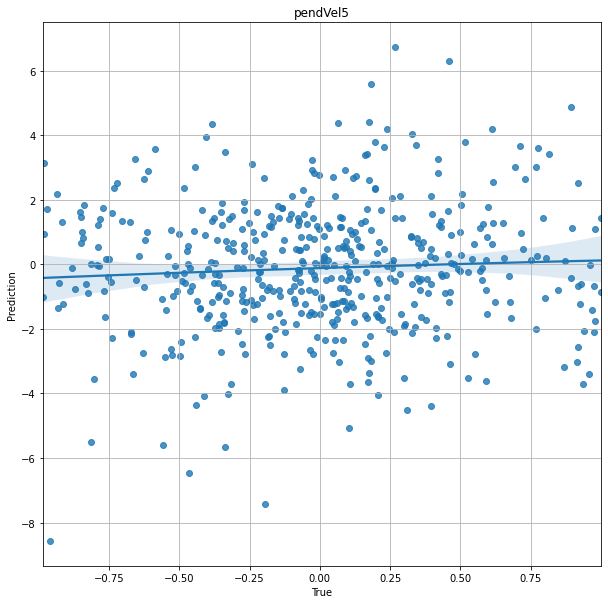

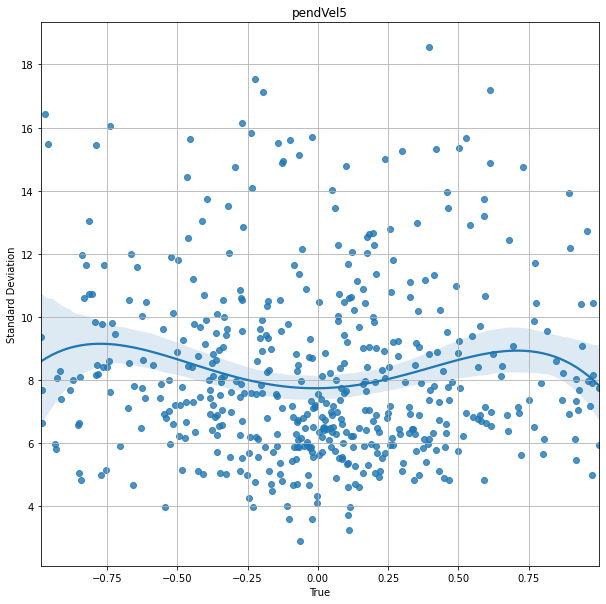

In [ ]:
Y_trueT = Y_true.transpose()
X_trueT = X_true.transpose()
Y_pred_sT = Y_pred_s.transpose()
Y_pred_mT = Y_pred_m.transpose()

for i in range(len(outputs)):
  fig, regplot = plt.subplots(figsize = (10,10))


  sb.regplot(x=Y_trueT[i], y=Y_pred_mT[i], fit_reg=True, scatter=True, order=2,truncate= True)

  regplot.set_xlabel("True")
  regplot.set_ylabel("Prediction")
  regplot.grid()

  plt.title(label=outputs[i])

  plt.savefig(fig_dir + "/ep2model_predictions_" + outputs[i] + ".png")

  fig, regplot = plt.subplots(figsize = (10,10))

  sb.regplot(x=Y_trueT[i], y=Y_pred_sT[i], fit_reg=True, scatter=True, order=4,truncate= True)

  regplot.set_xlabel("True")
  regplot.set_ylabel("Standard Deviation")
  regplot.grid()

  plt.title(label=outputs[i])

  plt.savefig(fig_dir + "/ep2model_sd_prediction_" + outputs[i] + ".png")

NLL based on https://fairyonice.github.io/Create-a-neural-net-with-a-negative-log-likelihood-as-a-loss.html and https://towardsdatascience.com/bayesian-neural-networks-with-tensorflow-probability-fbce27d6ef6


In [ ]:
def nll_gaussian (y_actual, y_predicted):
    y_pred_mean = y_predicted.mean()
    y_pred_sd = y_predicted.stddev()
    square = tf.square(y_pred_mean - y_actual)
    ms = tf.add(tf.divide(square,y_pred_sd), tf.math.log(y_pred_sd))
    ms = tf.reduce_mean(ms)
    return(ms)

In [ ]:
nll_epochs = 100
nll_train_ratio = 0.7

Aleatoric Uncertainity NNL

In [ ]:
def nll():
    return tfk.Sequential([
    tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
    tfk.layers.Dense(24, name="dense_1", activation="relu"),
    tfk.layers.Dense(12, name="dense_2", activation="relu"),
    tfk.layers.Dense(6, name="dense_3", activation="relu"),
    tfk.layers.Dense(1+1, name="output_prep"),
    tfp.layers.DistributionLambda( lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
])

In [ ]:
nllmodelpaths = []
for i in range(len(outputs)):
  nllmodelpaths.insert(i, model_dir + "/" + "nllmodel_" +outputs[i] + ".ckpt")

In [ ]:
nllmodels = []
for i in range(len(outputs)):
    nllmodels.insert(i,nll())
    nllmodels[i].compile(optimizer="adam", loss=nll_gaussian)
    nllmodels[i].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 78        
_________________________________________________________________
output_prep (Dense)          (None, 2)                 14        
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 992
Trainable params: 992
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output 

In [ ]:
for i in range(len(outputs)):
    start = time.time()
    nllmodels[i].fit(x=input_data, y=output_data[:,0], validation_split= nll_train_ratio, epochs=nll_epochs, verbose=True)
    nllmodels[i].save_weights(nllmodelpaths[i].format(epoch=0))
    end = time.time()
    print(end-start)

In [ ]:
for i in range(len(outputs)):
  nllmodels[i].load_weights(nllmodelpaths[i])

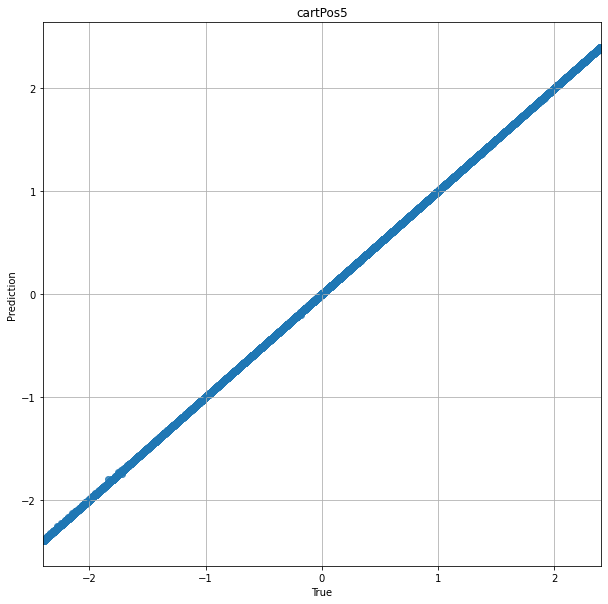

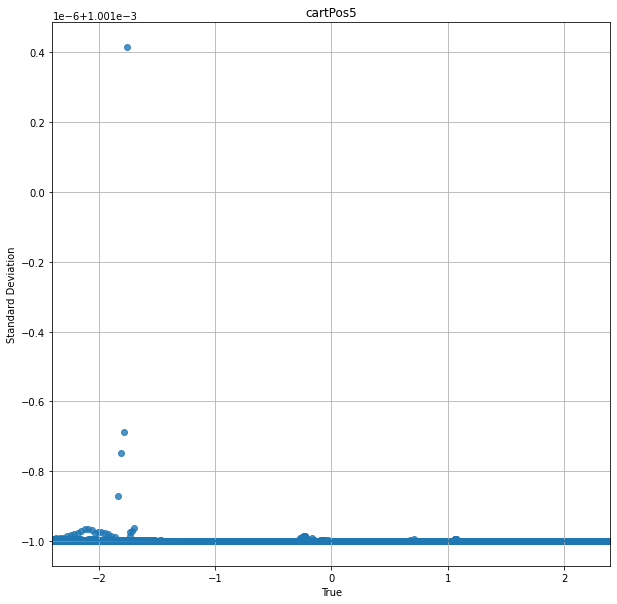

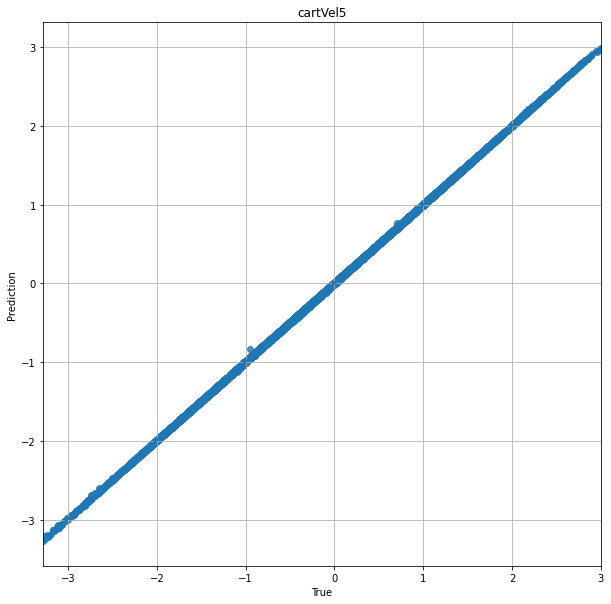

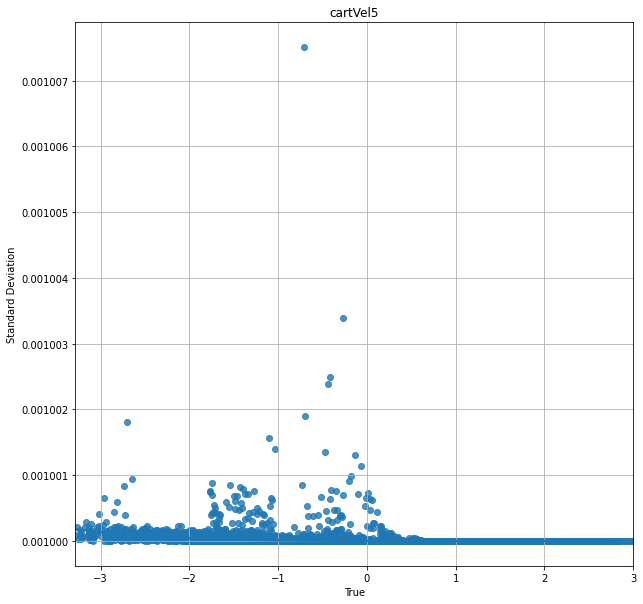

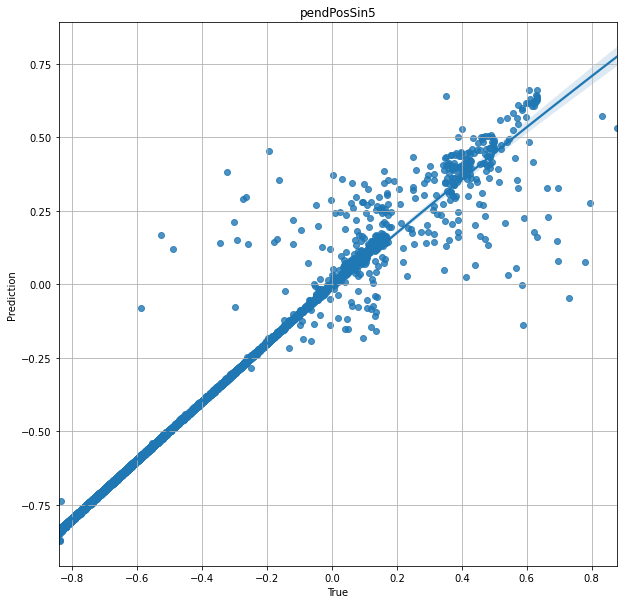

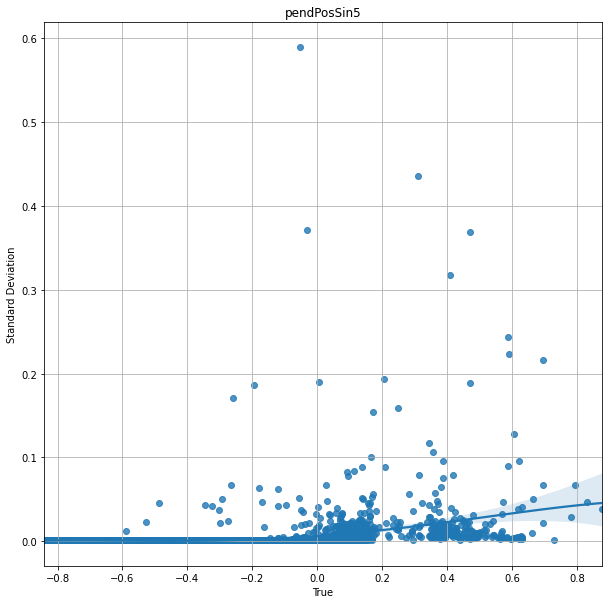

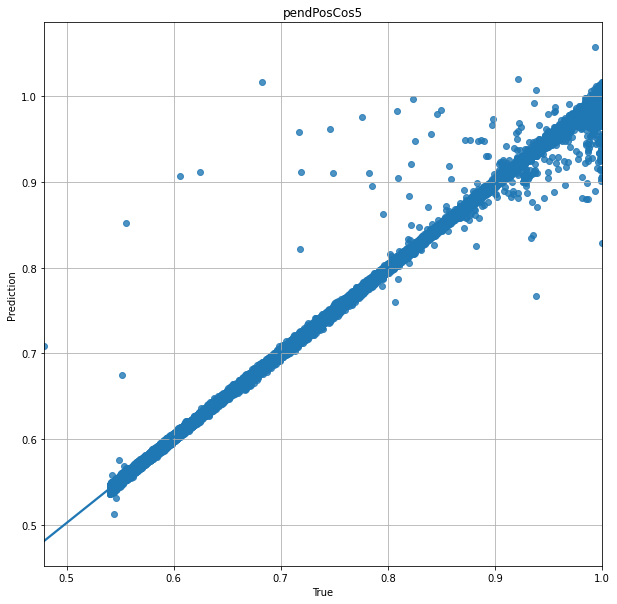

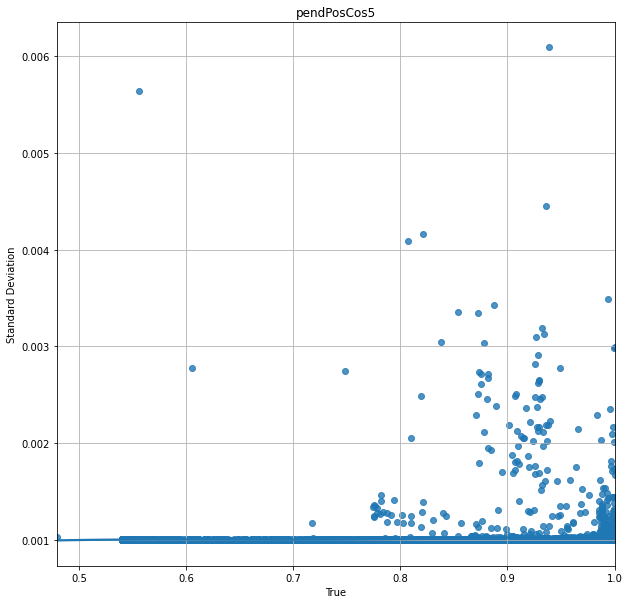

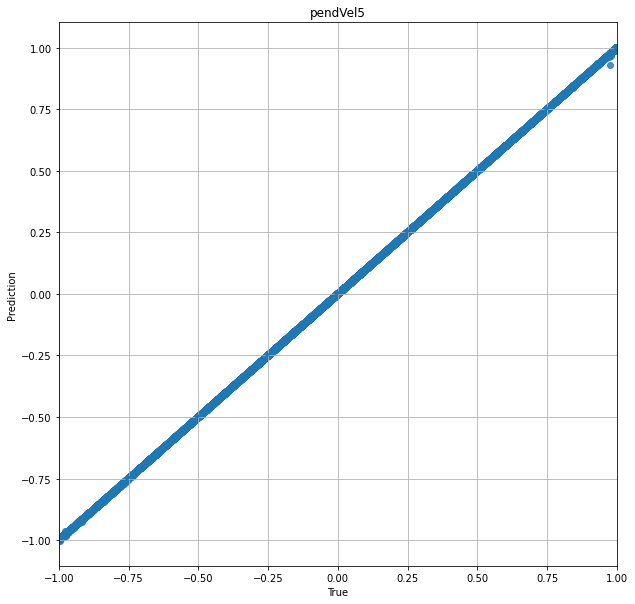

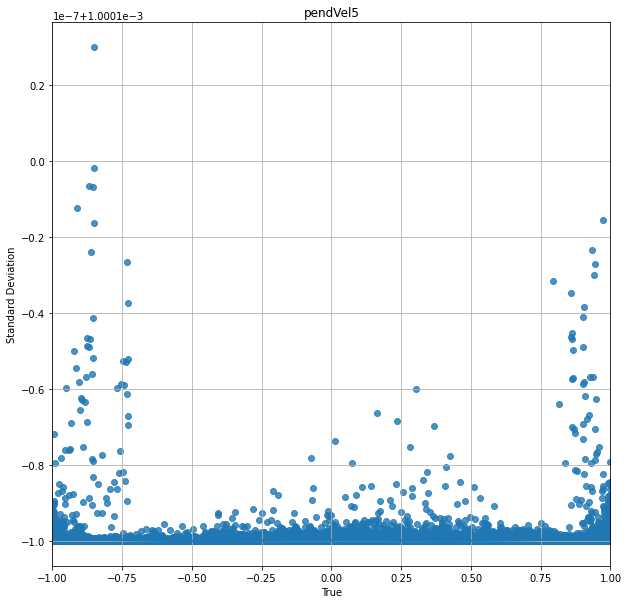

In [ ]:
for i in range(len(outputs)):
    
    yhat = nllmodels[i](input_data)
    mean = yhat.mean()
    stddev = yhat.stddev()  
    
    fig, regplot = plt.subplots(figsize = (10,10))


    sb.regplot(x=output_data[:,i], y=mean[:].numpy(), fit_reg=True, scatter=True, order=2,truncate= True)

    regplot.set_xlabel("True")
    regplot.set_ylabel("Prediction")
    regplot.grid()
    plt.title(label=outputs[i])
    plt.savefig(fig_dir + "/nnlmodel_predictions_" + outputs[i] + ".png")
    
    fig, regplot = plt.subplots(figsize = (10,10))

    sb.regplot(x=output_data[:,i], y=stddev[:].numpy(), fit_reg=True, scatter=True, order=4,truncate= True)

    regplot.set_xlabel("True")
    regplot.set_ylabel("Standard Deviation")
    regplot.grid()
    plt.title(label=outputs[i])
    plt.savefig(fig_dir + "nnlmodel_sd_prediction_" + outputs[i] + ".png")

Epistemic Uncertainity NNL

In [ ]:
ep_nll_ensemble_size = 20 #choose < 32 due to np.ndarray limitations for fast calculation

In [ ]:
def nll_ep():
    return tfk.Sequential([
    tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, activation="relu"),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

In [ ]:
epnllmodelpaths = []
for i in range(len(outputs)):
  epnllmodelpaths.insert(i, model_dir + "/" + "epnllmodel_" +outputs[i] + ".ckpt")

In [ ]:
epnllmodels = []
for i in range(len(outputs)):
    start = time.time()
    
    epnllmodels.insert(i,nll_ep())
    epnllmodels[i].compile(optimizer="adam", loss=nll_gaussian)
    epnllmodels[i].summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_2 (DenseVa (None, 1)                 75        
_________________________________________________________________
distribution_lambda_5 (Distr multiple                  0         
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_3 (DenseVa (None, 1)                 75        
_________________________________________________________________
distribution_lambda_6 (Distr multiple                  0         
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
__________________

In [ ]:
for i in range(len(outputs)):
    start = time.time()
    epnllmodels[i].fit(x=input_data, y=output_data[:,i], validation_split= nll_train_ratio, epochs=nnl_epochs,  verbose=True)
    epnllmodels[i].save_weights(epnllmodelpaths[i].format(epoch=0))
    end = time.time()
    print(end-start)

In [ ]:
for i in range(len(outputs)):
  epnllmodels[i].load_weights(epnllmodelpaths[i])

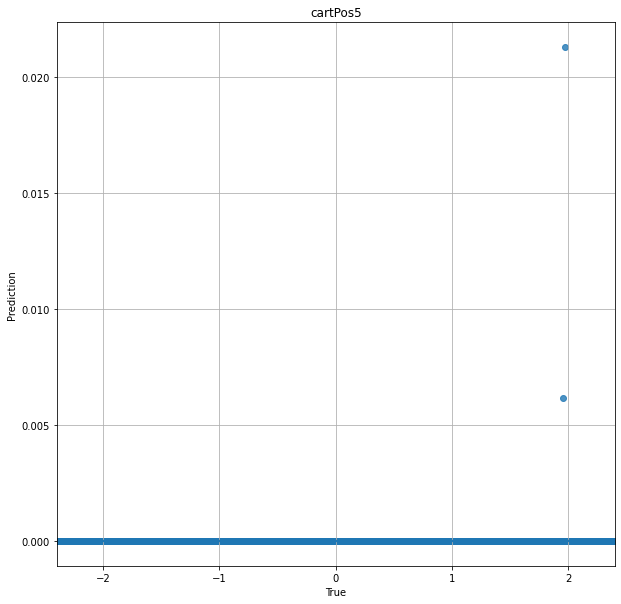

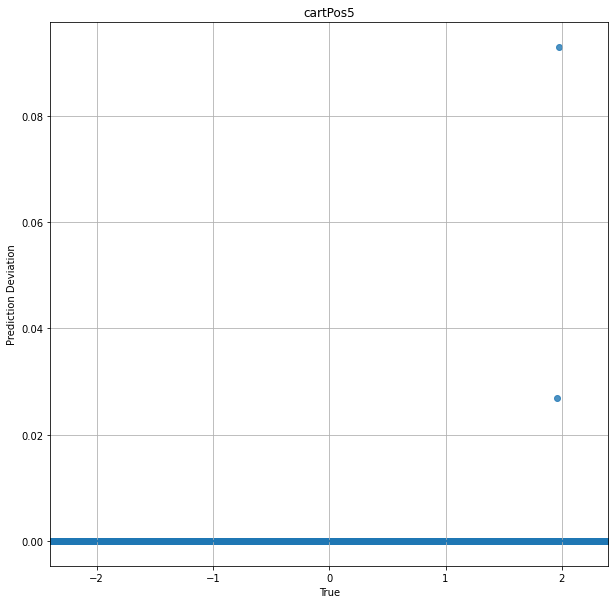

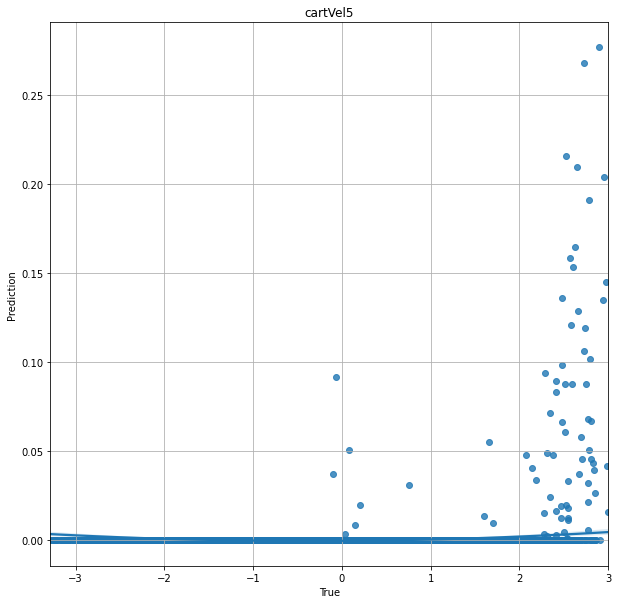

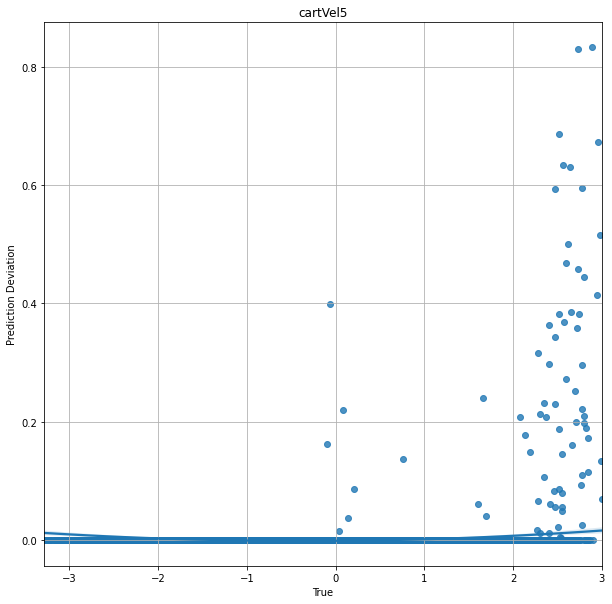

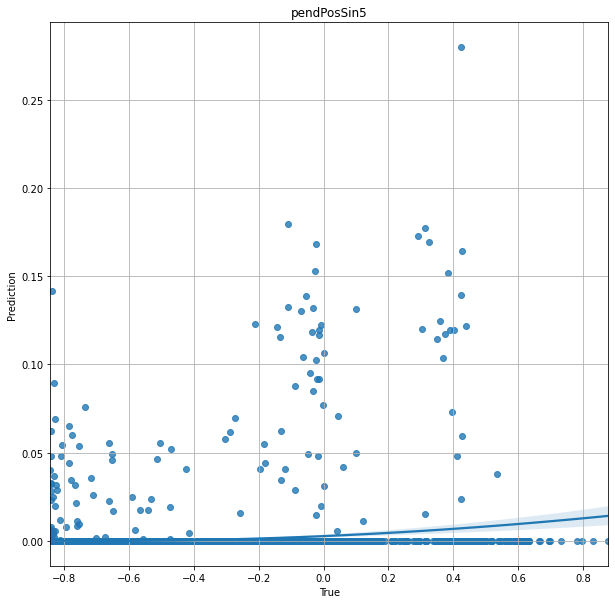

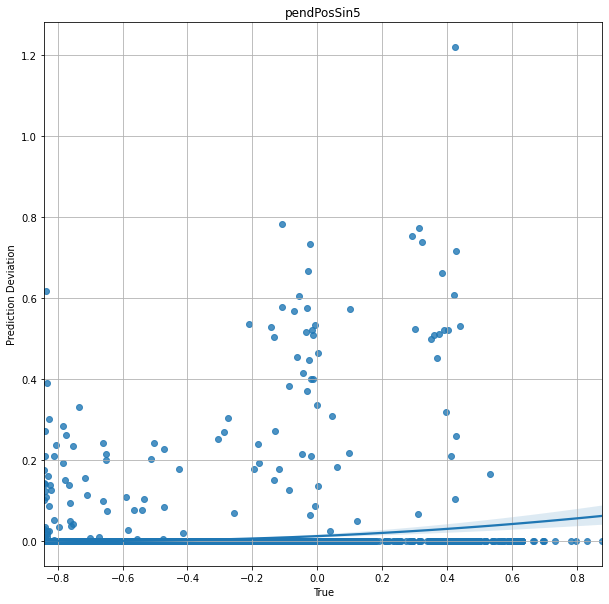

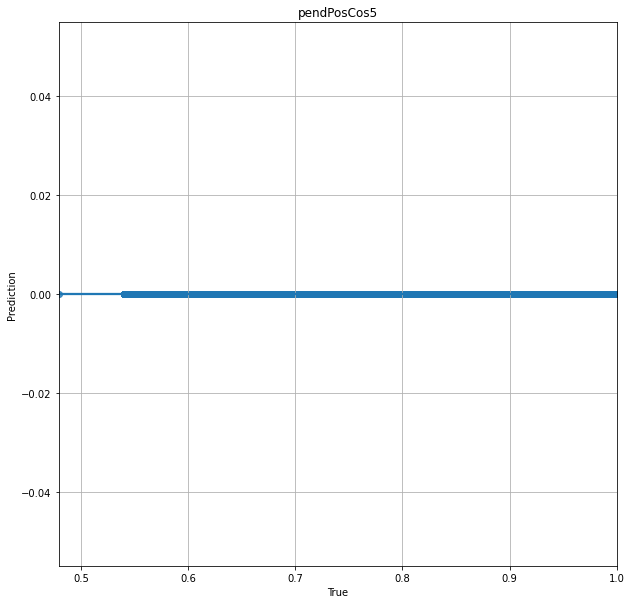

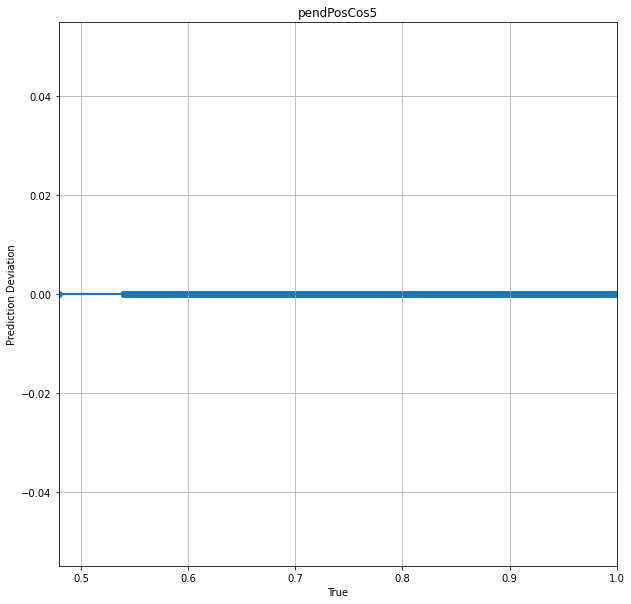

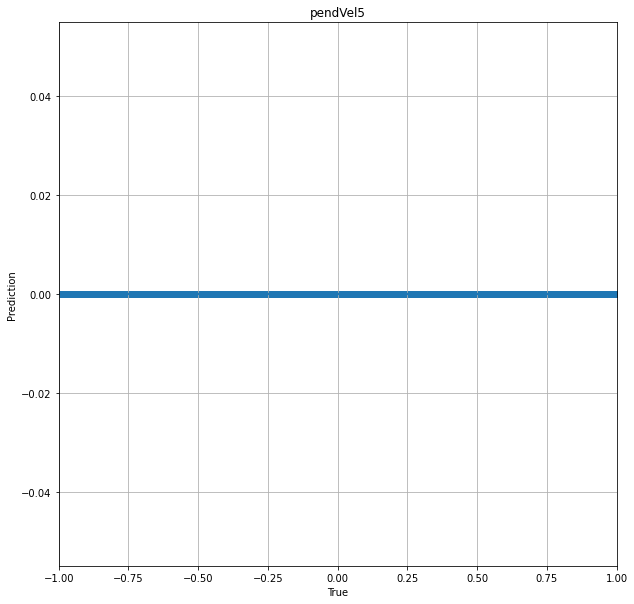

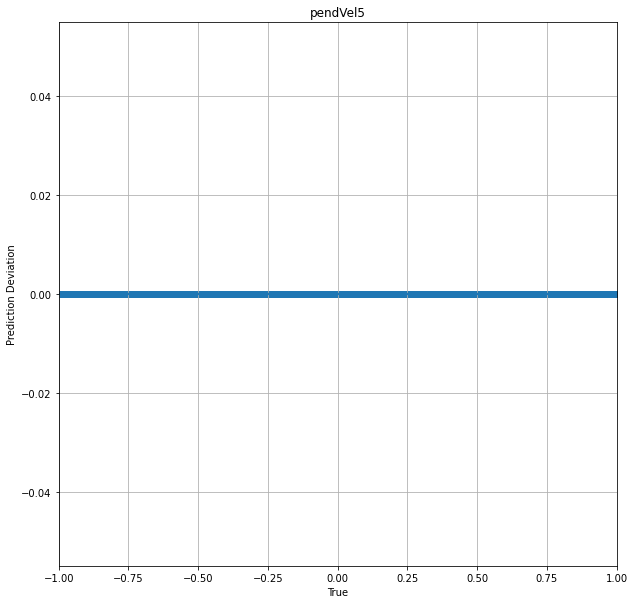

In [ ]:
for i in range(len(outputs)):
    
    yhats = [epnllmodels[i](input_data) for j in range(ep_nll_ensemble_size)]
    
    means = np.empty((len(yhats[0].mean()),0))
    stddevs = np.empty((len(yhats[0].mean()),0))
    
    for k in range(len(yhats)):
        mean = yhats[k].mean().numpy()
        stddev = yhats[k].stddev().numpy()
        means = np.append(means,mean, axis=1)
        stddevs = np.append(stddevs,stddev, axis=1)
    
    fig, regplot = plt.subplots(figsize = (10,10))


    sb.regplot(x=output_data[:,i], y=np.mean(means, axis=1), fit_reg=True, scatter=True, order=2,truncate= True)

    regplot.set_xlabel("True")
    regplot.set_ylabel("Prediction")
    regplot.grid()
    plt.title(label=outputs[i])
    plt.savefig(fig_dir + "/ep_nnlmodel_predictions_" + outputs[i] + ".png")
    
    fig, regplot = plt.subplots(figsize = (10,10))
    
    sb.regplot(x=output_data[:,i], y=np.std(means, axis=1), fit_reg=True, scatter=True, order=2,truncate= True)

    regplot.set_xlabel("True")
    regplot.set_ylabel("Prediction Deviation")
    regplot.grid()
    plt.title(label=outputs[i])
    plt.savefig(fig_dir + "/ep_nnlmodel_predictions_sd_" + outputs[i] + ".png")

Noised Observation Wrapper with BNN

In [ ]:
uncertainty_malus = -100

In [ ]:
std_means = []

for i in range(len(outputs)):
  yhat = nllmodels[i](input_data)
  std_means.insert(i,np.mean(yhat.stddev().numpy()))


std_mean_sum = np.sum(np.array(std_means))
print(std_means)

[0.0010000001852446046, 0.0010000037187623168, 0.0011494053425537415, 0.001002901893506481, 0.0010000001861079216]


In [ ]:
def stdUncertaintyNLLNoBonus (input_data):
  means = []
  stddevs = []
  for i in range(len(outputs)):
      yhat = nllmodels[i](input_data)
      stddevs.insert(i,yhat.stddev())
  uncertainty = max(0, np.sum(np.array(stddevs)) - std_mean_sum)
  
  return uncertainty

In [ ]:
def stdUncertaintyNLLBonus (input_data):
  means = []
  stddevs = []
  for i in range(len(outputs)):
      yhat = nllmodels[i](input_data)
      stddevs.insert(i,yhat.stddev())
  uncertainty = np.sum(np.array(stddevs)) - std_mean_sum

  return uncertainty

In [ ]:
def stdweightedUncertaintyNLL (input_data):
  means = []
  stddevs = []
  for i in range(len(outputs)):
      yhat = nllmodels[i](input_data)
      stddevs.insert(i,yhat.stddev())

  stddevs = np.array(stddevs)
  print("means " + str(means))
  print("stdevs " + str(stddevs))


  uncertainty = np.sum(np.array(stddevs))
  print(uncertainty)

  print(str(uncertainty*uncertainty_malus))
  
  return uncertainty

In [ ]:
def meandistUncertaintyNLL (input_data):
  means = []
  stddevs = []
  for i in range(len(outputs)):
      yhat = nllmodels[i](input_data)
      means.insert(i,yhat.mean())
      stddevs.insert(i,yhat.stddev())

  print("means " + str(means))
  print("stdevs " + str(stddevs))

  uncertainty = np.sum(np.array(stddevs))
  print(uncertainty)

  print(str(uncertainty*uncertainty_malus))
  
  return uncertainty

In [ ]:
class NoisedObservationWrapperWithUncertaintyModelMalus(gym.Wrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))

    def __init__(self, env, history, std_dev=0.3, mean=0, angle_min=10, angle_max=20, local_path="false",):
        super().__init__(env)
        self.env = env
        self.std_dev = std_dev
        self.mean = mean
        self.angle_min = np.radians(angle_min)
        self.angle_max = np.radians(angle_max)
        self.local_path = local_path
        self.history = history
        
        if(self.local_path != "false"):
            log_file = open(self.local_path, "w")
            log_file.close()

    def step(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)




        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        history = self.history
        print("History: " + str(history))

        if len(history) >= markov_head:
          cur_markov = np.concatenate(history).ravel()
          cur_markov.shape = (1,(len(inputs)))

          uncertainty = stdUncertaintyNLL(cur_markov)

          reward = reward + uncertainty*uncertainty_malus

        pendPos = observation[2]
        pendPosSin = math.sin(pendPos)
        pendPosCos = math.cos(pendPos)

        new_data = np.array(observation)
        new_data[2] = pendPosSin
        new_data = np.insert(new_data, 3, pendPosCos)

        history.append(new_data)
        if len(history) > markov_head:
          del(history[0])

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()

           
            
        return observation, reward, done, info
    
    def step_noise(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        old_reward = reward

        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        history = self.history

        if len(history) >= markov_head:
          cur_markov = np.concatenate(history).ravel()
          cur_markov.shape = (1,(len(inputs)))

          uncertainty = stdUncertaintyNLL(cur_markov)
          
          reward = reward + uncertainty*uncertainty_malus

        pendPos = observation[2]
        pendPosSin = math.sin(pendPos)
        pendPosCos = math.cos(pendPos)

        new_data = np.array(observation)
        new_data[2] = pendPosSin
        new_data = np.insert(new_data, 3, pendPosCos)


        history.append(observation)
        if len(history) >= markov_head:
          del(history[0])

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info, noisy, uncertainty, old_reward

In [ ]:
env3history = []
env3Test = NoisedObservationWrapperWithUncertaintyModelMalus(gym.make("CartPoleSwingUp-v0"), history = env3history)
env3Test = Monitor(env3Test, log_dir+str(3)) # required for using callback functions during training
env3Test = DummyVecEnv([lambda: env3Test])
env3Test = VecNormalize(env3Test, norm_obs=True, norm_reward=True) # State normalization

In [ ]:
env3Test.reset()
env3Test.step(env3Test.action_space.sample())
env3Test.step(env3Test.action_space.sample())
env3Test.step(env3Test.action_space.sample())
env3Test.step(env3Test.action_space.sample())
env3Test.step(env3Test.action_space.sample())
print("")

History: [array([-0.20664014, -0.06694576, -0.82578444,  0.5639859 ,  0.2366637 ,
        0.19661476], dtype=float32), array([-0.20730959, -0.18672398, -0.8260457 ,  0.56360316,  0.23475295,
        0.5456545 ], dtype=float32), array([-0.20917684, -0.06970618, -0.82675886,  0.5625565 ,  0.22944541,
        0.31891698], dtype=float32), array([-0.2098739 , -0.21588962, -0.82716745,  0.5619555 ,  0.22634017,
        0.7309545 ], dtype=float32)]
0
History: [array([-0.20730959, -0.18672398, -0.8260457 ,  0.56360316,  0.23475295,
        0.5456545 ], dtype=float32), array([-0.20917684, -0.06970618, -0.82675886,  0.5625565 ,  0.22944541,
        0.31891698], dtype=float32), array([-0.2098739 , -0.21588962, -0.82716745,  0.5619555 ,  0.22634017,
        0.7309545 ], dtype=float32), array([ 0.32638946, -0.04763857, -0.84103924,  0.54097414, -0.03995598,
       -0.14149633], dtype=float32)]
0
History: [array([-0.20917684, -0.06970618, -0.82675886,  0.5625565 ,  0.22944541,
        0.31891698], d

Test Environments

In [ ]:
env1Test = gym.make('CartPoleSwingUp-v0')
env1Test = Monitor(env1Test, log_dir1) # required for using callback functions during training
env1Test = DummyVecEnv([lambda: env1Test])
env1Test = VecNormalize(env1Test, norm_obs=True, norm_reward=True) # State normalization

In [ ]:
env2Test = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"))
env2Test = Monitor(env2Test, log_dir2) # required for using callback functions during training
env2Test = DummyVecEnv([lambda: env2Test])
env2Test = VecNormalize(env2Test, norm_obs=True, norm_reward=True) # State normalization

Experiment settings

In [ ]:
time_steps=30000
num_experiments = 10
sampleCount = 100

Experiments without Uncertainty

In [ ]:
tensorboard_dir1 = "cartpole1"
os.makedirs(tensorboard_dir1, exist_ok=True)
times = []
for e in range (1, (num_experiments+1), 1):
    env1Test.reset()
    log_dire = (log_dir1+ str(e))
    os.makedirs(log_dire, exist_ok=True)
    env1 = gym.make('CartPoleSwingUp-v0')
    env1 = Monitor(env1, log_dire) # required for using callback functions during training
    env1 = DummyVecEnv([lambda: env1])
    env1 = VecNormalize(env1, norm_obs=True, norm_reward=True) # State normalization
    model1 = PPO(MlpPolicy, env1, verbose=0)
    
    clear_output(wait=True)
    print("Run " +  str(e))
    

    eval_callback = EvalCallback(env1Test, best_model_save_path=log_dire,
                             log_path=log_dire, eval_freq=1000,
                             deterministic=True, render=False)
    
    
    start = time.time()
    model1.learn(total_timesteps=time_steps, callback=eval_callback)
    end = time.time()
    times.insert((e-1),end-start)
    env1.close()
print(times)    
    

Run 10
Eval num_timesteps=1000, episode_reward=-491.44 +/- 8.36
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-492.88 +/- 6.45
Episode length: 500.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-200.73 +/- 25.56
Episode length: 203.80 +/- 26.57
New best mean reward!
Eval num_timesteps=4000, episode_reward=-218.20 +/- 39.80
Episode length: 223.40 +/- 41.08
Eval num_timesteps=5000, episode_reward=-150.84 +/- 9.17
Episode length: 172.00 +/- 24.68
New best mean reward!
Eval num_timesteps=6000, episode_reward=-149.80 +/- 15.62
Episode length: 224.00 +/- 133.61
New best mean reward!
Eval num_timesteps=7000, episode_reward=-140.47 +/- 21.50
Episode length: 175.20 +/- 60.23
New best mean reward!
Eval num_timesteps=8000, episode_reward=-115.34 +/- 9.52
Episode length: 128.00 +/- 8.07
New best mean reward!
Eval num_timesteps=9000, episode_reward=-105.63 +/- 34.58
Episode length: 124.00 +/- 28.48
New best mean reward!
Eval num_timesteps=10000, 

Experiment Results without Uncertainty

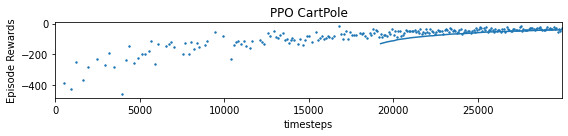

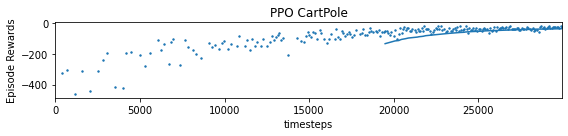

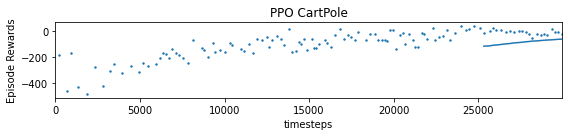

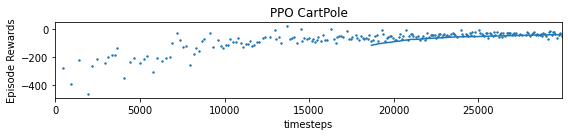

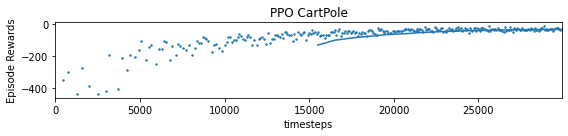

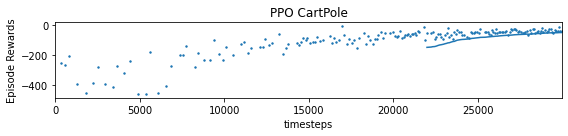

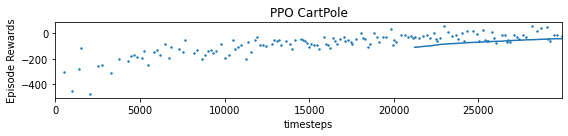

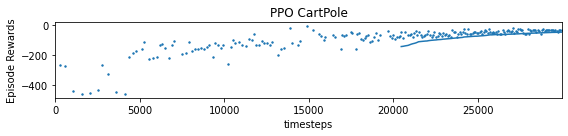

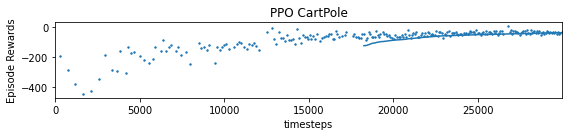

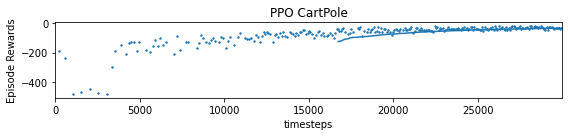

In [ ]:
for e in range (1, (num_experiments+1), 1):
    results_plotter.plot_results([log_dir1+str(e)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole")

    plt.savefig(fig_dir + "/Results_PPO_" + str(e)  + ".png")
    plt.show()


Best Policy: 7


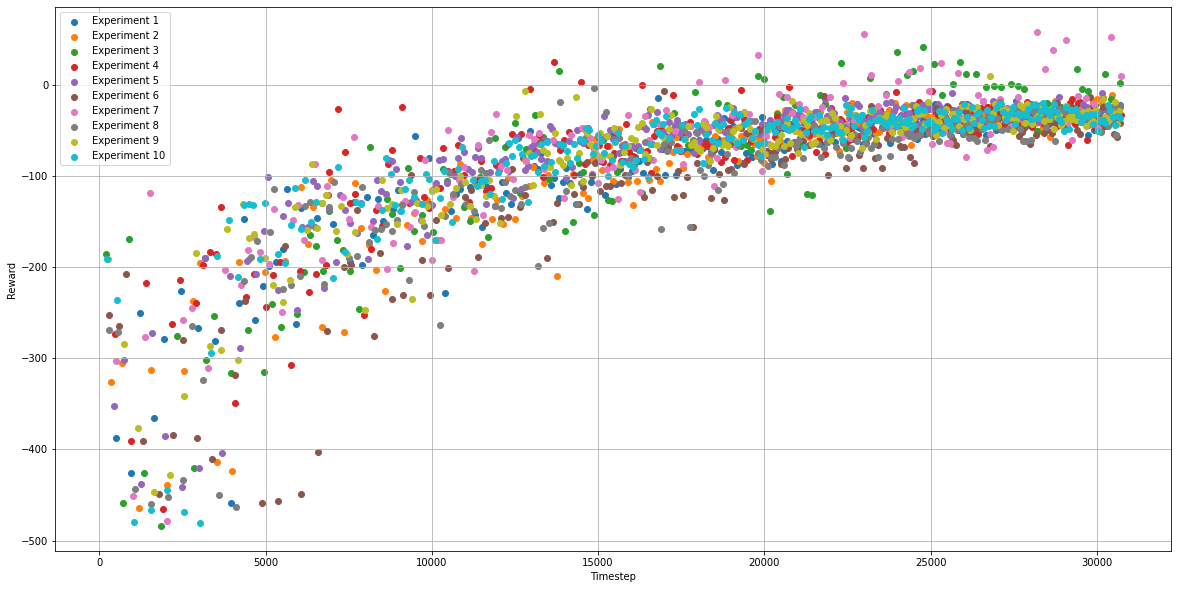

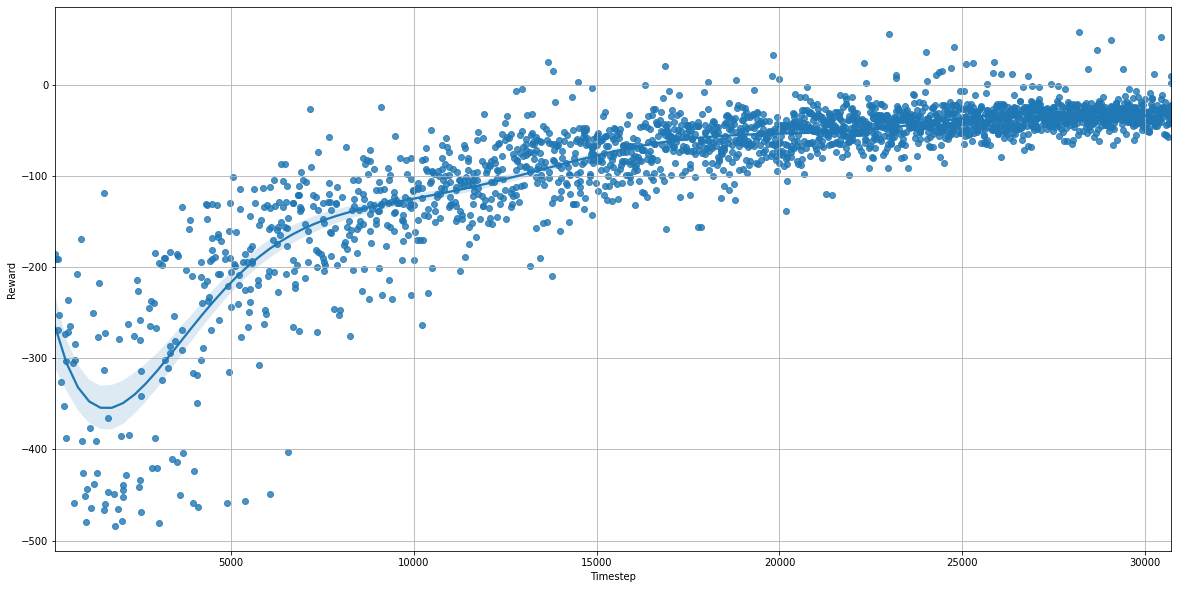

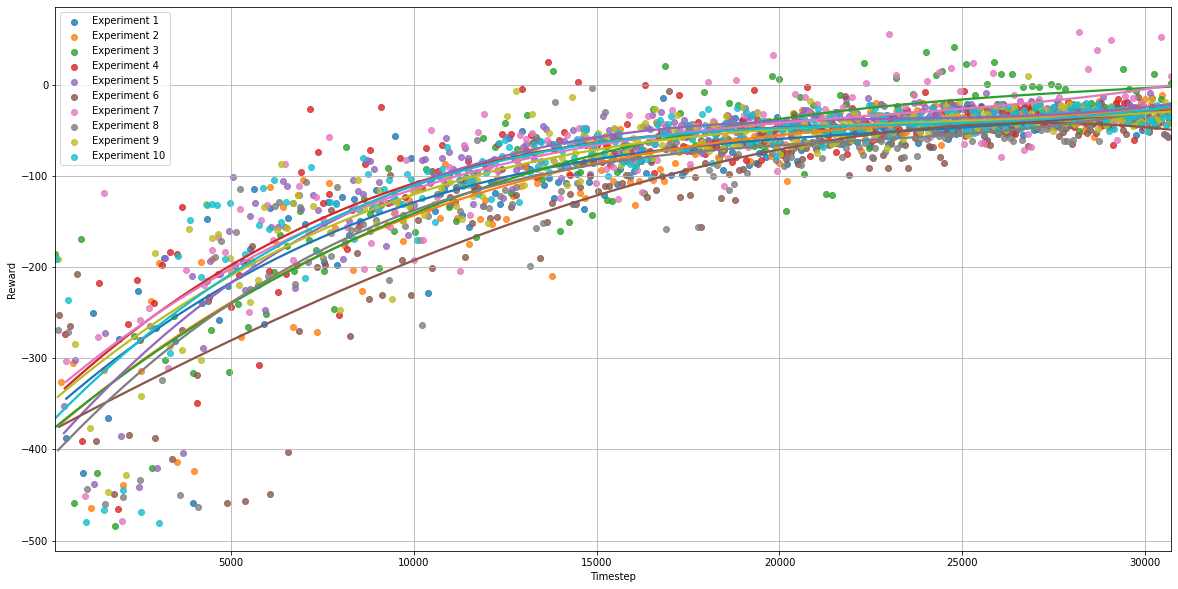

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

store1 = pd.DataFrame()
exps1 = []

maxreward1 = - math.inf
best1 = 0

for e in range (1, (num_experiments+1), 1):
    log_dire = (log_dir1+ str(e))
    x, y = ts2xy(load_results(log_dire), 'timesteps')
    plt.scatter(x=x, y=y, label="Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp1 = pd.DataFrame(d)
    exps1.append(exp1)
    store1 = store1.append(exp1, ignore_index=True)
    if (np.max(y) > maxreward1):
      maxreward1 = np.max(y)
      best1 = e

print("Best Policy: " + str(best1))

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")

#plt.plot(x_mean, y_mean)
#print(store1)

plt.savefig(fig_dir + "/Results_PPO_Points.png")
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
regplot=sb.regplot(x="x", y="y", data=store1, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")

plt.savefig(fig_dir + "/Results_PPO_Combined.png")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp1 in exps1:
    i += 1
    sb.regplot(x="x", y="y", data=exp1, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label="Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.savefig(fig_dir + "/Results_PPO_Regression.png")
plt.show()

In [ ]:
import pandas as pd
path = googledrive_dir + "logs11/monitor.csv"
data = pd.read_csv(str(path), engine='python', index_col=None, skiprows=1)
#print(data)
data.sum(axis=0)


r   -19614.790597
l    30698.000000
t    14377.496998
dtype: float64

Experiments with Uncertainty

In [ ]:
tensorboard_dir2 = "cartpole2"
os.makedirs(tensorboard_dir2, exist_ok=True)
times = []
for e in range (1, (num_experiments+1), 1):

    log_dire = (log_dir2 + str(e))
    os.makedirs(log_dire, exist_ok=True)
    env2 = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"))
    env2 = Monitor(env2, log_dire) # required for using callback functions during training
    env2 = DummyVecEnv([lambda: env2])
    env2 = VecNormalize(env2, norm_obs=True, norm_reward=True)

    model2 = PPO(MlpPolicy, env2, verbose=0)

    clear_output(wait=True)
    print("Run " +  str(e))

    eval_callback = EvalCallback(env2Test, best_model_save_path=log_dire,
                             log_path=log_dire, eval_freq=1000,
                             deterministic=True, render=False)

    start = time.time()
    model2.learn(total_timesteps=time_steps, callback=eval_callback)
    end = time.time()
    times.insert((e-1),end-start)
    env2.close()
print(times)

Run 10
Eval num_timesteps=1000, episode_reward=-491.22 +/- 12.82
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-497.41 +/- 2.62
Episode length: 500.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-385.39 +/- 82.08
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-389.81 +/- 56.45
Episode length: 500.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-218.81 +/- 20.34
Episode length: 329.60 +/- 91.36
New best mean reward!
Eval num_timesteps=6000, episode_reward=-205.96 +/- 74.61
Episode length: 377.00 +/- 107.53
New best mean reward!
Eval num_timesteps=7000, episode_reward=-132.23 +/- 31.00
Episode length: 141.00 +/- 27.31
New best mean reward!
Eval num_timesteps=8000, episode_reward=-124.54 +/- 9.47
Episode length: 155.40 +/- 24.09
New best mean reward!
Eval num_timesteps=9000, episode_reward=-112.16 +/- 19.70
Episode length: 149.60 +/- 26.99
New best mean reward!
Eval num_timesteps=10000,

Experiment Results with Uncertainty 

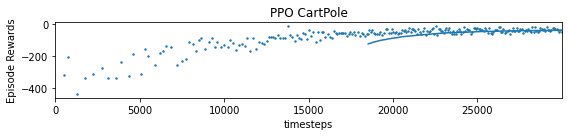

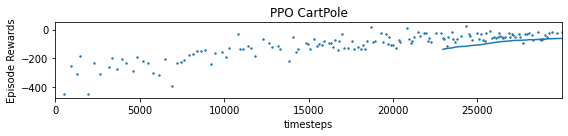

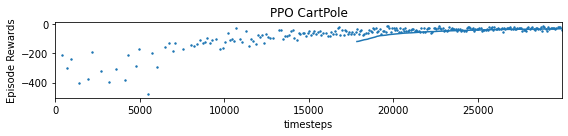

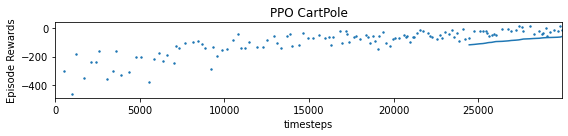

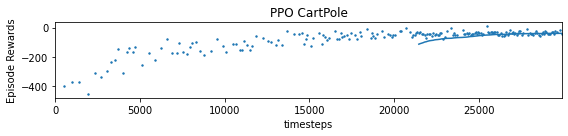

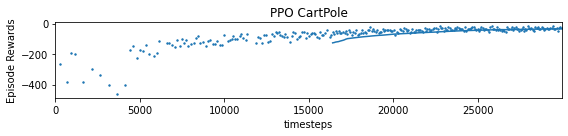

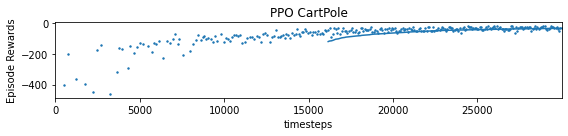

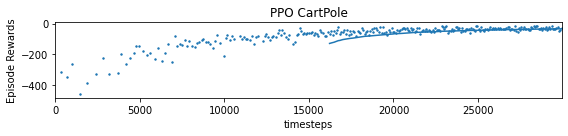

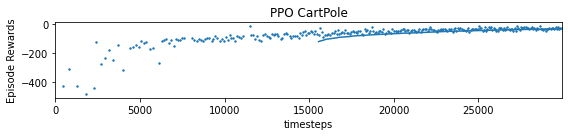

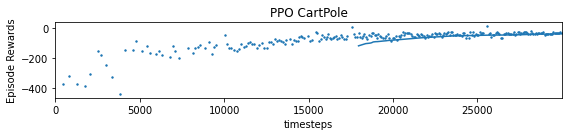

In [ ]:
for e in range (1, (num_experiments+1), 1):

    results_plotter.plot_results([log_dir2+str(e)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole")
    plt.savefig(fig_dir + "/Results_PPO_Uncertain_" + str(e)  + ".png")
    plt.show()

Best Policy: 2


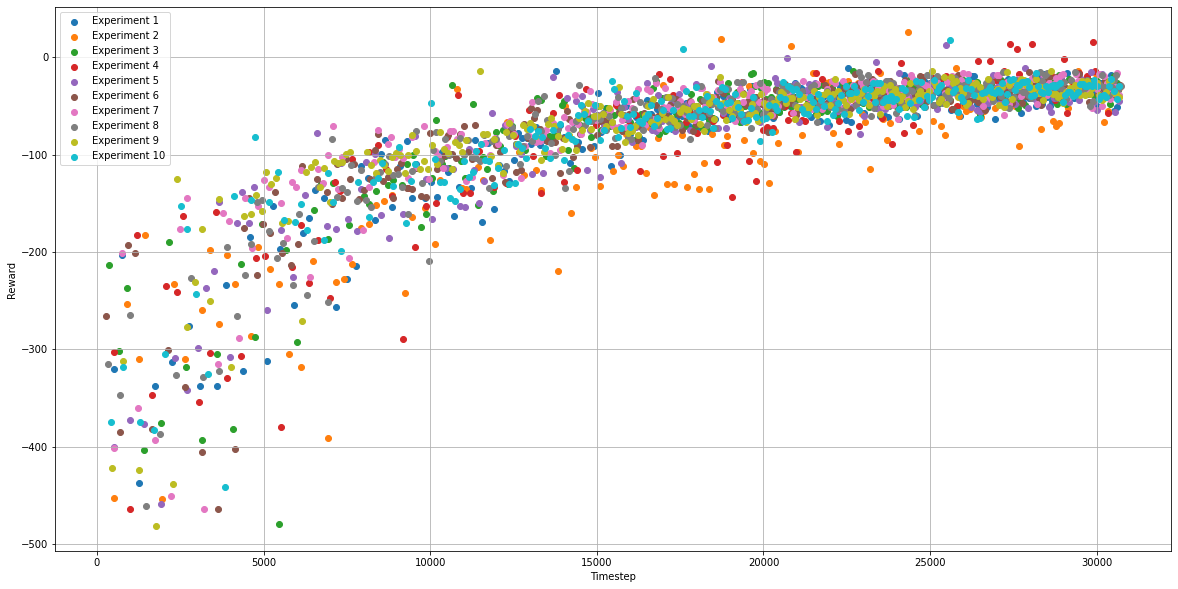

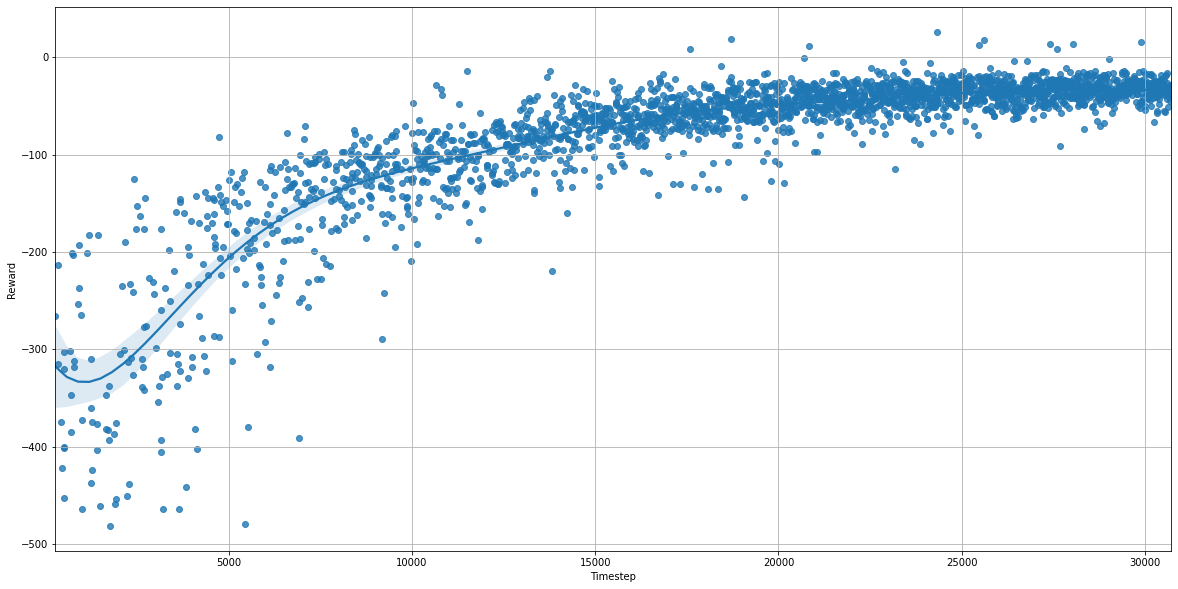

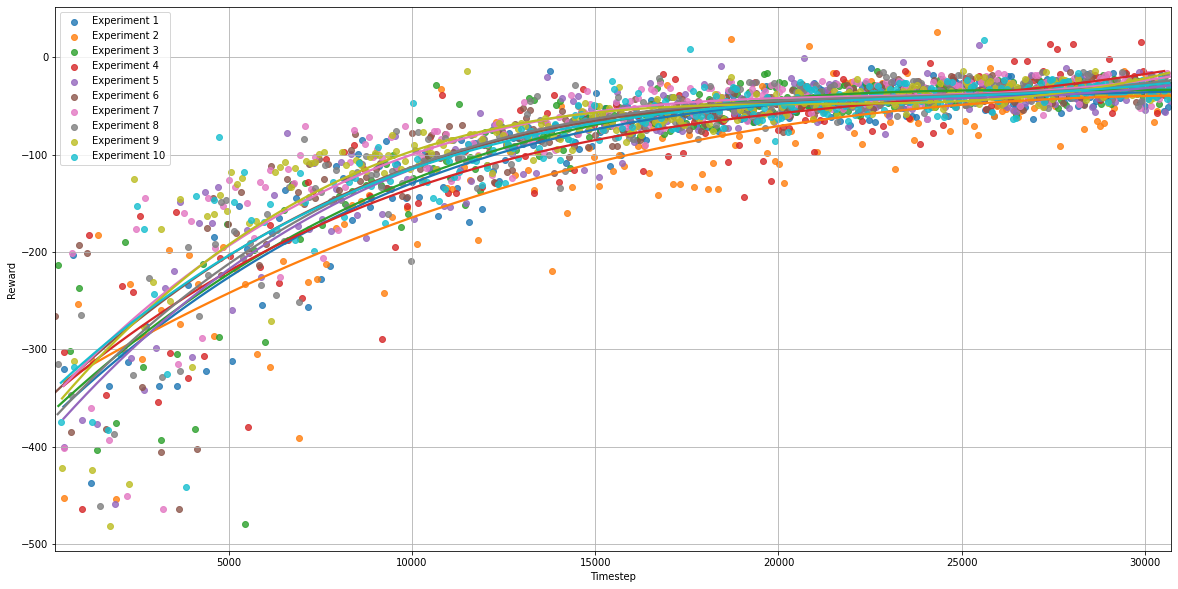

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

maxreward2 = -math.inf
best2 = 0

store2 = pd.DataFrame()
exps2 = []
for e in range (1, (num_experiments+1), 1):
    log_dire = (log_dir2+ str(e))
    x, y = ts2xy(load_results(log_dire), 'timesteps')
    plt.scatter(x=x, y=y, label = "Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp2 = pd.DataFrame(d)
    exps2.append(exp2)
    store2 = store2.append(exp2, ignore_index=True)
    if (np.max(y) > maxreward2):
      maxreward2 = np.max(y)
      best2 = e

print("Best Policy: " + str(best2))

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")
#plt.plot(x_mean, y_mean)
#print(store)
plt.savefig(fig_dir + "/Results_PPO_Uncertain_Points.png")
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
fig.clf()
regplot=sb.regplot(x="x", y="y", data=store2, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")
plt.savefig(fig_dir + "/Results_PPO_Uncertain_Combined.png")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp2 in exps2:
    i += 1
    sb.regplot(x="x", y="y", data=exp2, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label = "Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.savefig(fig_dir + "/Results_PPO_Uncertain_Regression.png")
plt.show()



Evaluation of best model



In [221]:
models = []
models.append(PPO.load("%s/best_model.zip" % (log_dir1+str(best1))))
models.append(PPO.load("%s/best_model.zip" % (log_dir2+str(best2))))

index = []
index.append(1)
index.append(2)

In [222]:
env1 = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"), local_path="test.txt")
env1 = Monitor(env1, log_dir1)
env1.training=False

env2 = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"), local_path="test.txt")
env2 = Monitor(env2, log_dir2)
env2.training=False

envs = []
envs.append(env1)
envs.append(env2)

In [228]:
expver = 1

In [224]:
print(str(index[expver]))
print(log_dir)

1
/content/drive/MyDrive/ARL/logs


In [230]:

expCounter = []

exp = 1

while exp <= sampleCount:
    state = envs[expver].reset()
    done=False
    cumReward = 0
    cumOldReward = 0
    cumUncertainty = 0
    steps=0
    noise = 0
    neg = 0
    pos = 0

    negReward = 0
    negNoise = 0
    negUncertainty = 0

    posReward = 0
    posNoise = 0
    posUncertainty = 0

    noise_uncertainty = 0
    non_noise_uncertainty = 0

    while not done: 
        steps += 1
        action, _states = models[expver].predict(state)
        state, reward, done, _, noisy, uncertainty, old_reward = envs[expver].step_examine(action)
        cumReward += reward
        cumOldReward += old_reward
        cumUncertainty += uncertainty
        
        if (action[0]> 0):
            pos += 1
            posReward += reward
            posUncertainty += uncertainty
            if noisy:
              posNoise += 1
        elif (action[0]< 0):
            neg += 1
            negReward += reward
            negUncertainty += uncertainty
            if noisy:
              negNoise += 1

        if noisy:
            noise += 1
            noise_uncertainty += uncertainty
        else:
            non_noise_uncertainty += uncertainty

    envs[expver].close()
    
    expCounter.append([steps, cumReward, noise, cumUncertainty, cumOldReward, neg, pos, negReward, posReward, negNoise, posNoise, negUncertainty, posUncertainty, noise_uncertainty, non_noise_uncertainty])
    
    clear_output(wait=True)
    print("Experiment " +  str(exp) + " Reward: " + str(cumReward) + " (" + str(cumOldReward) + ") Steps: " + str(neg) + "/" + str(pos) + " Noise: " + str(noise) + " Uncertainty: " + str(cumUncertainty))
    exp+= 1

results = np.mat(expCounter)

resultsdf = pd.DataFrame(data=results, columns=["steps", "reward", "noise", "uncertainty", "oldReward", "neg", "pos", "negReward", "posReward", "negNoise", "posNoise", "negUncertainty", "posUncertainty", "noisyUncertainty", "notNoisyUncertainty"])
resultsdf.to_csv(path_or_buf=log_dir + str(index[expver]) + "/results.csv", index=False)

#print(results)
clear_output(wait=True)

print ("Average Reward: %.3f" % (np.mean(np.array(results[:,1]))))
print ("Average Step Count: %.3f" % (np.mean(np.array(results[:,0]))))
print ("Average Noise: %.3f" % (np.mean(np.array(results[:,2]))))
print ("Average Noise per Length: %.3f" % (np.mean(np.divide(np.array(results[:,2]),np.array(results[:,0])))))
print("Uncertainty: " + str(np.sum(np.array(results[:,3]))))
print("Steps Ratio (Neg): " + str(np.mean(np.divide(np.array(results[:,5]),np.array(results[:,0])))))
print("Steps Ratio (Pos): " + str(np.mean(np.divide(np.array(results[:,6]),np.array(results[:,0])))))
print("Average Reward per Negative: " + str(np.mean(np.array(results[:,7]))))
print("Average Reward per Positive: " + str(np.mean(np.array(results[:,8]))))
print("Average Noise per Negative: " + str(np.mean(np.array(results[:,9]))))
print("Average Noise per Positive: " + str(np.mean(np.array(results[:,10]))))
print("Average Uncertainty per Negative: " + str(np.mean(np.array(results[:,11]))))
print("Average Uncertainty per Positive: " + str(np.mean(np.array(results[:,12]))))
print("Average Uncertainty for Noise: " + str(np.mean(np.array(results[:,13]))))
print("Average Uncertainty for no Noise: " + str(np.mean(np.array(results[:,14]))))

Average Reward: -61.036
Average Step Count: 109.830
Average Noise: 1.690
Average Noise per Length: 0.012
Uncertainty: 0.0
Steps Ratio (Neg): 0.6648175377828928
Steps Ratio (Pos): 0.3351824622171071
Average Reward per Negative: -41.557993700269144
Average Reward per Positive: -19.478059520719107
Average Noise per Negative: 0.86
Average Noise per Positive: 0.83
Average Uncertainty per Negative: 0.0
Average Uncertainty per Positive: 0.0
Average Uncertainty for Noise: 0.0
Average Uncertainty for no Noise: 0.0


In [227]:
loaded1 = pd.read_csv(log_dir + "1/results.csv", engine='python', index_col=None)
print(loaded1)

    steps     reward  ...  noisyUncertainty  notNoisyUncertainty
0   106.0 -55.861957  ...               0.0                  0.0
1   195.0 -22.033677  ...               0.0                  0.0
2   101.0 -58.137377  ...               0.0                  0.0
3    80.0 -33.668254  ...               0.0                  0.0
4   117.0 -68.499609  ...               0.0                  0.0
..    ...        ...  ...               ...                  ...
95  192.0  28.930971  ...               0.0                  0.0
96  101.0 -68.718108  ...               0.0                  0.0
97  200.0 -29.056764  ...               0.0                  0.0
98  127.0 -45.651048  ...               0.0                  0.0
99   90.0 -64.285133  ...               0.0                  0.0

[100 rows x 15 columns]


Graph Content


In [ ]:
variants = ["PPO (Base, no noise)", "PPO (Base, noise)"]

In [ ]:
stepCounter = []
rewardCounter = []
noiseCounter = []
negCounter = []
posCounter = []
avgNoiseCounter = []
negRewardCounter = []
posRewardCounter = []
negNoiseCounter = []
posNoiseCounter = []
stepRatio = []

for i in range(len(variants)) :
  loaded = pd.read_csv(log_dir + str(i+1) + "/results.csv", engine='python', index_col=None)
  stepCounter.append(np.array(loaded["steps"]))
  rewardCounter.append(np.array(loaded["reward"]))
  noiseCounter.append(np.array(loaded["noise"]))
  negCounter.append(np.array(loaded["neg"]))
  posCounter.append(np.array(loaded["pos"]))
  avgNoiseCounter.append(np.divide(np.array(loaded["noise"]),np.array(loaded["steps"])))
  negRewardCounter.append(np.array(loaded["negReward"]))
  posRewardCounter.append(np.array(loaded["posReward"]))
  negNoiseCounter.append(np.array(loaded["negNoise"]))
  posNoiseCounter.append(np.array(loaded["posNoise"]))
  stepRatio.append(np.divide(np.array(loaded["neg"]),np.array(loaded["steps"])))

Experiment Length

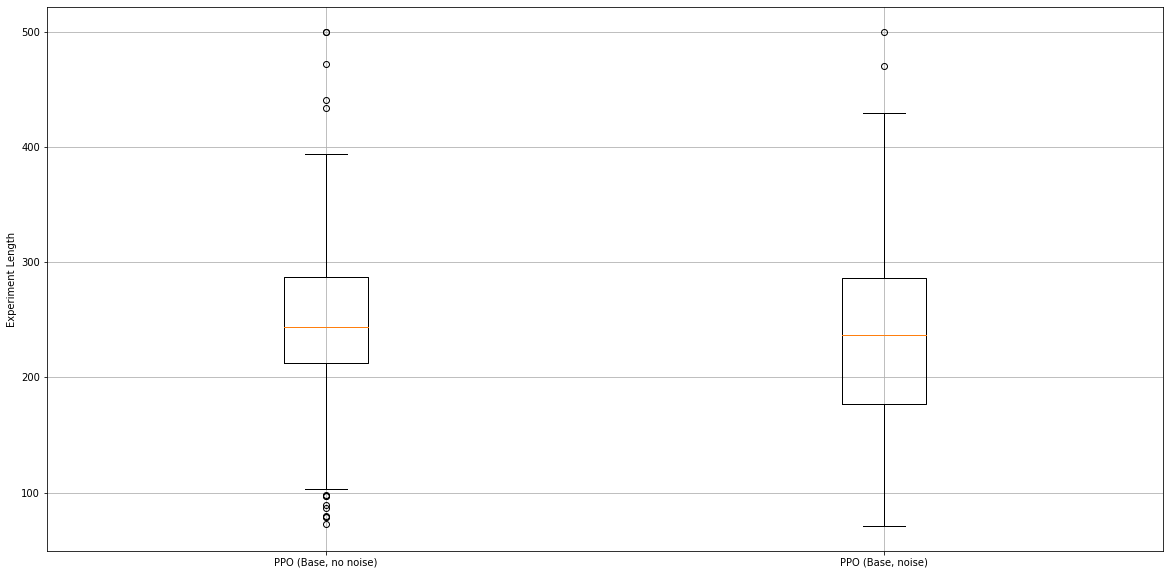

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

boxplot_data  = {}
for i in range(len(variants)):
 boxplot_data[variants[i]] = np.reshape(stepCounter[i],newshape=-1)

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Experiment Length")
plt.savefig(fig_dir + "/ExperimentLength.png")
plt.show()

Noise per Experiment Length

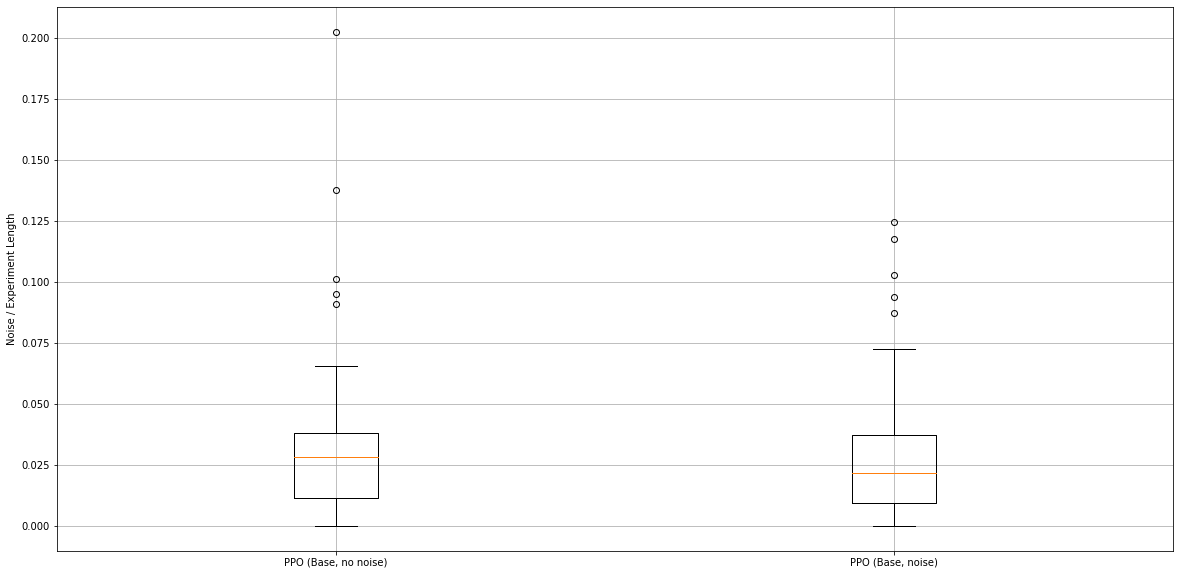

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

boxplot_data  = {}
for i in range(len(variants)):
 boxplot_data[variants[i]] = np.reshape(np.divide(noiseCounter[i],stepCounter[i]),newshape=-1)

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Noise / Experiment Length")
plt.savefig(fig_dir + "/Noise+ExperimentLength.png")
plt.show()

Noise per Length

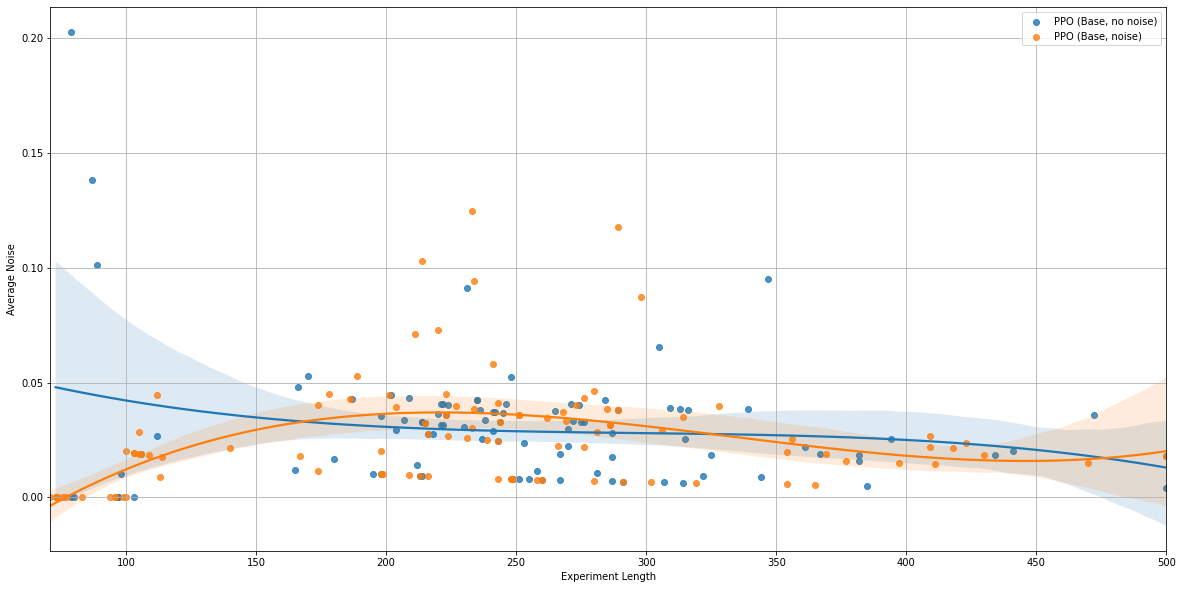

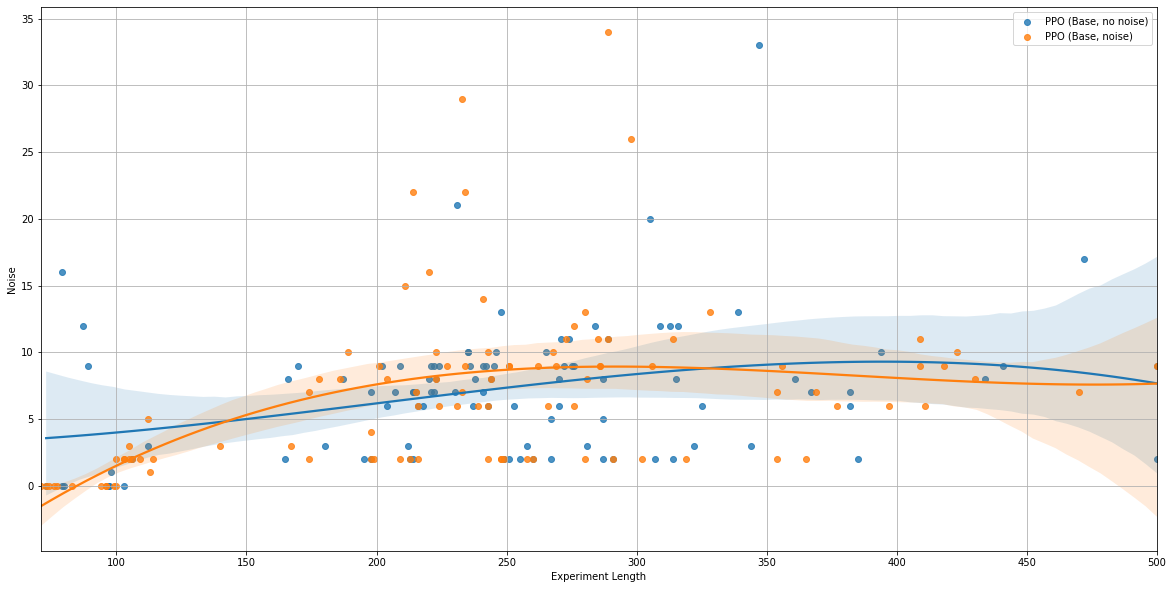

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepCounter[i],-1), y=np.reshape(avgNoiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.legend()
regplot.set_ylabel("Average Noise")
regplot.set_xlabel("Experiment Length")
regplot.grid()
plt.savefig(fig_dir + "/AvNoiseLength.png")
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepCounter[i],-1), y=np.reshape(noiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Noise")
regplot.set_xlabel("Experiment Length")
regplot.legend()
regplot.grid()
plt.savefig(fig_dir + "/NoiseLength.png")
plt.show()

Noise per Reward

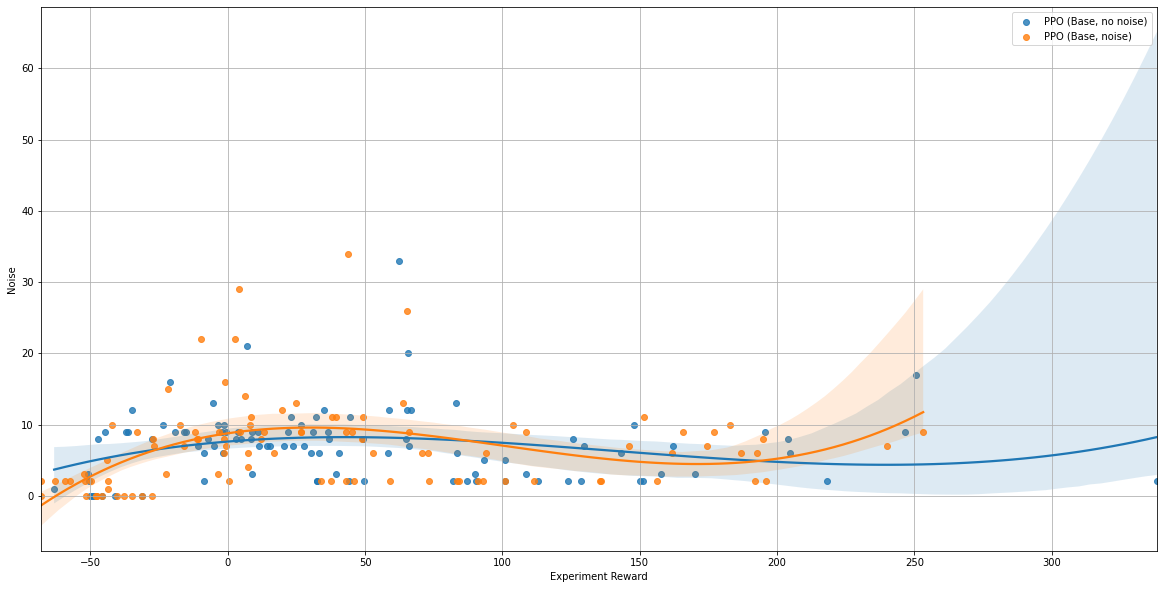

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(rewardCounter[i],-1), y=np.reshape(noiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Noise")
regplot.set_xlabel("Experiment Reward")
regplot.legend()
regplot.grid()
plt.savefig(fig_dir + "/NoiseReward.png")
plt.show()

Reward per Experiment Length

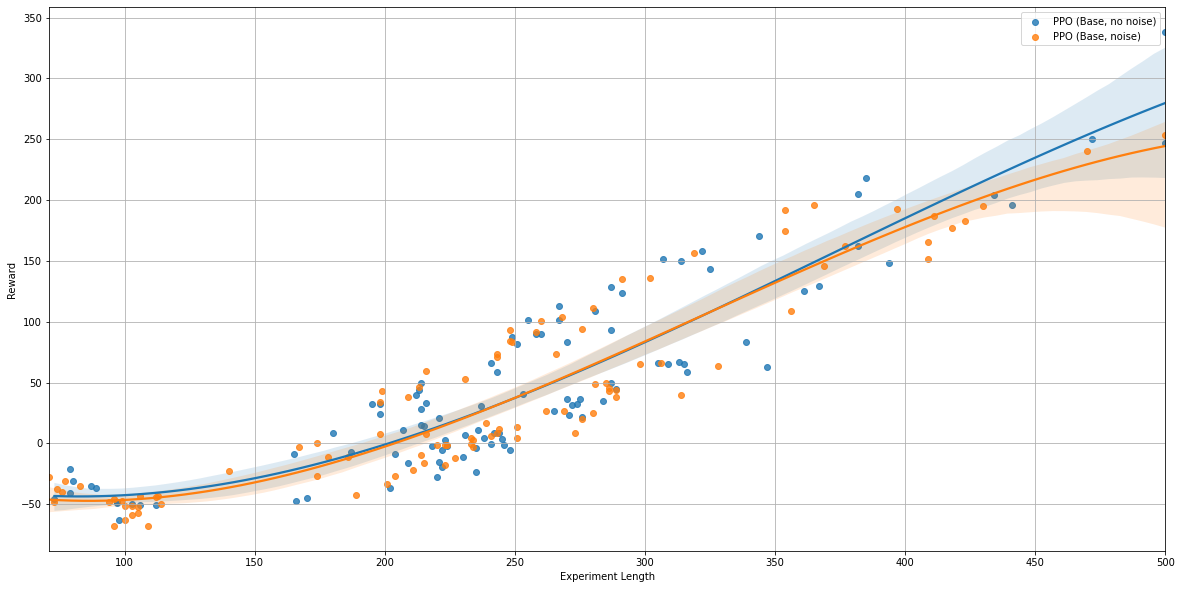

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepCounter[i],-1), y=np.reshape(rewardCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Reward")
regplot.set_xlabel("Experiment Length")
regplot.legend()
regplot.grid()
plt.savefig(fig_dir + "/RewardLength.png")
plt.show()

Direction

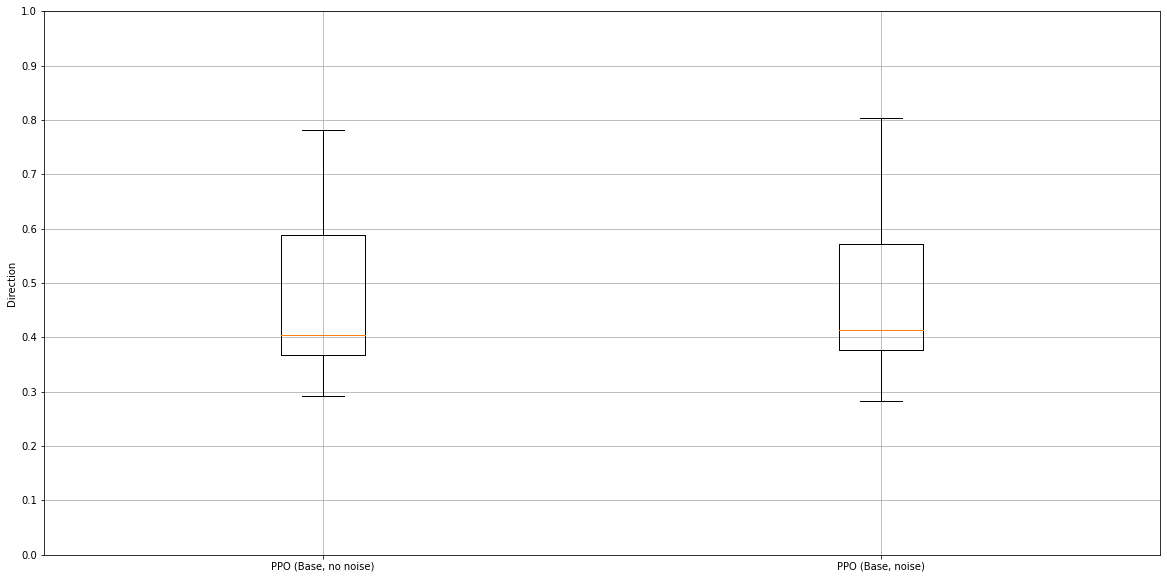

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()


boxplot_data  = {}
for i in range(len(variants)):
 boxplot_data[variants[i]] = np.reshape(stepRatio[i],newshape=-1)

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Direction")

plt.ylim(0,1)
plt.yticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/ExperimentDirection.png")
plt.show()

Experiment Length per Direction

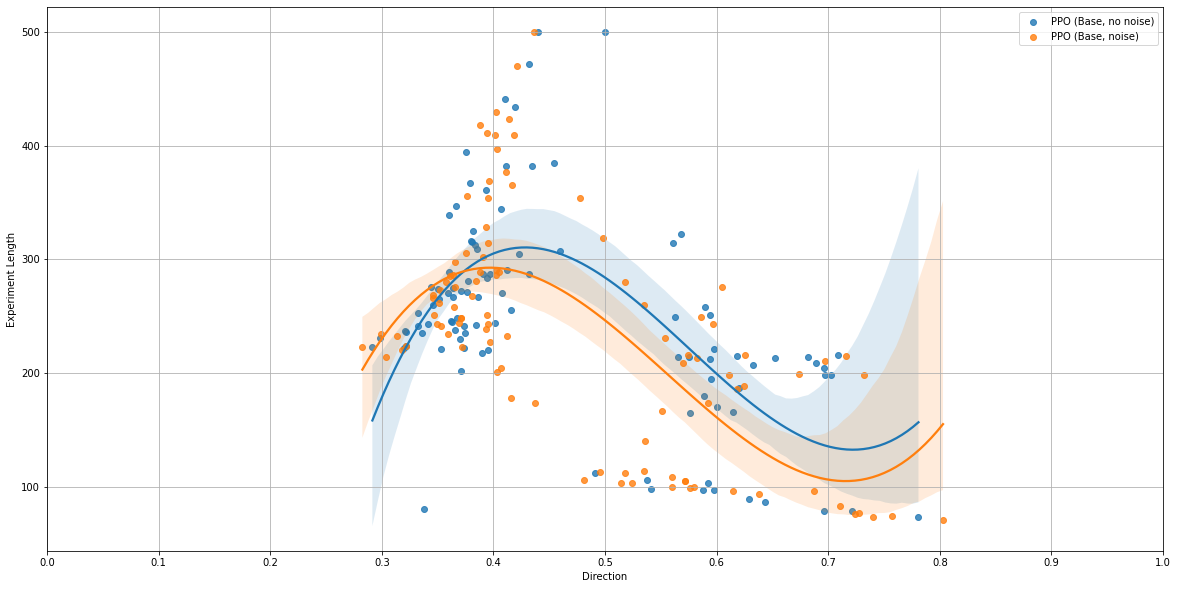

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(stepCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Experiment Length")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/DirectionLength.png")
plt.show()

Reward per Direction

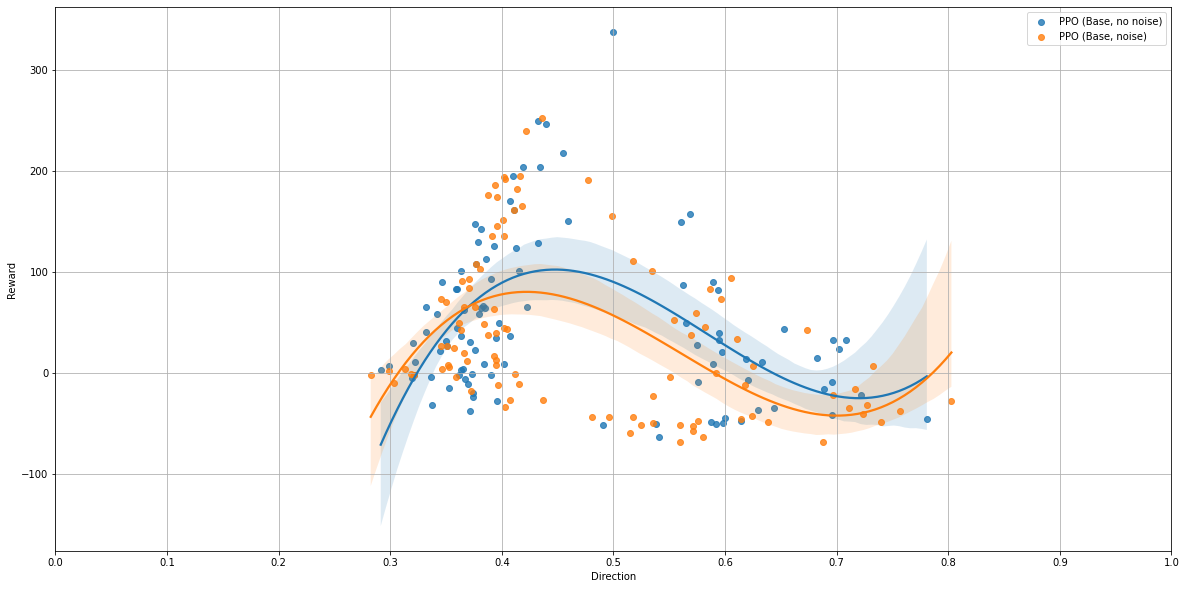

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(rewardCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Reward")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/RewardDirection.png")
plt.show()

Noise per Direction

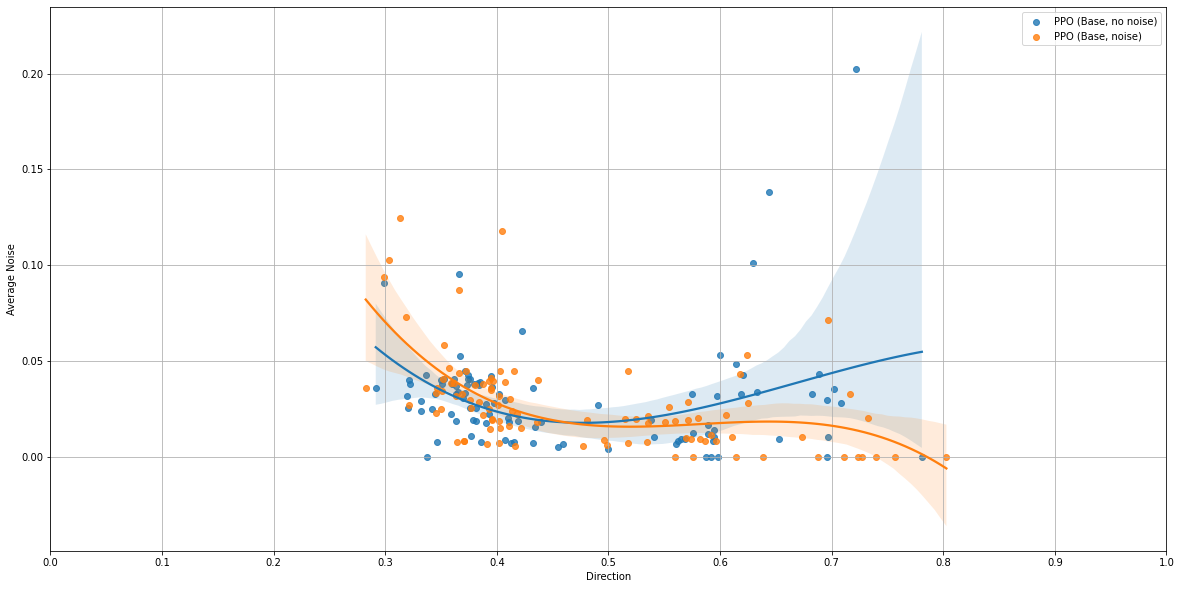

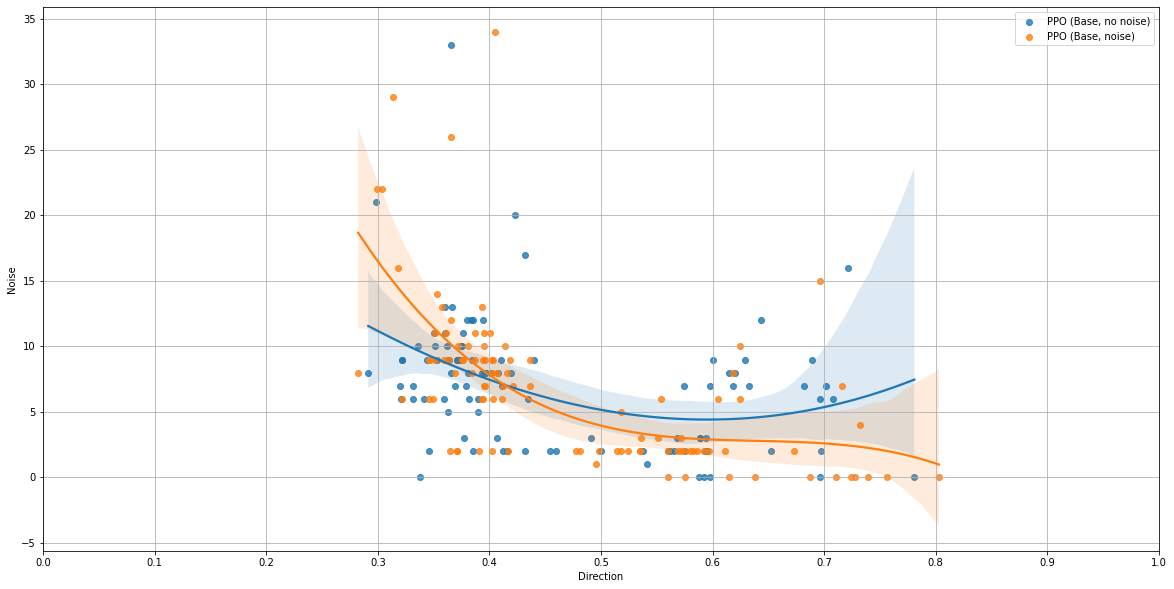

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))


for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(avgNoiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.legend()
regplot.set_ylabel("Average Noise")
regplot.set_xlabel("Direction")
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(noiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Noise")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/NoiseDirection.png")
plt.show()